In [44]:
import re
import math
import torch
import metrics
import ordpy as op
import numpy as np
import pandas as pd
import ruptures as rpt
import scipy.stats as st
import colorednoise as cn
# from klcpd import KL_CPD
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
from xgboost import XGBClassifier
from collections import OrderedDict
from LSTM.models import binary_model
from catboost import CatBoostClassifier
from IPython.display import clear_output
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from ruptures.metrics import randindex, precision_recall
from data_generation2 import Binary_Telegraph_Process as BTP
# from sklearn.model_selection import train_test_split as tts
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import balanced_accuracy_score, f1_score, auc, precision_recall_curve

import warnings
warnings.filterwarnings('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [45]:
class synth_cpd_pipeline(object):
    def __init__(self, method='log-return', sample_len=10000, n_epochs=100, save_results=False):
        
        self.data   = {r'GAZP, $\alpha = 1$':[], r'GAZP, $\alpha = 2$':[], r'GAZP, $\alpha = \pi$':[],
                       r'LKOH, $\alpha = 1$':[], r'LKOH, $\alpha = 2$':[], r'LKOH, $\alpha = \pi$':[], 
                       r'NVTK, $\alpha = 1$':[], r'NVTK, $\alpha = 2$':[], r'NVTK, $\alpha = \pi$':[],
                       r'ROSN, $\alpha = 1$':[], r'ROSN, $\alpha = 2$':[], r'ROSN, $\alpha = \pi$':[], 
                       r'SBER, $\alpha = 1$':[], r'SBER, $\alpha = 2$':[], r'SBER, $\alpha = \pi$':[],
                       r'SBERP, $\alpha = 1$':[], r'SBERP, $\alpha = 2$':[], r'SBERP, $\alpha = \pi$':[],
                       r'TCSG, $\alpha = 1$':[], r'TCSG, $\alpha = 2$':[], r'TCSG, $\alpha = \pi$':[],
                       r'TRUR, $\alpha = 1$':[], r'TRUR, $\alpha = 2$':[], r'TRUR, $\alpha = \pi$':[],
                       r'VTBR, $\alpha = 1$':[], r'VTBR, $\alpha = 2$':[], r'VTBR, $\alpha = \pi$':[],
                       r'YNDX, $\alpha = 1$':[], r'YNDX, $\alpha = 2$':[], r'YNDX, $\alpha = \pi$':[]}
        self.labels = []
        self.lr     = []
        self.noise  = [r'GAZP, $\alpha = 1$', r'LKOH, $\alpha = 1$', r'NVTK, $\alpha = 1$', r'ROSN, $\alpha = 1$', r'SBER, $\alpha = 1$', r'TCSG, $\alpha = 1$', r'SBERP, $\alpha = 1$', r'TRUR, $\alpha = 1$', r'VTBR, $\alpha = 1$', r'YNDX, $\alpha = 1$',
                       r'GAZP, $\alpha = 2$', r'LKOH, $\alpha = 2$', r'NVTK, $\alpha = 2$', r'ROSN, $\alpha = 2$', r'SBER, $\alpha = 2$', r'TCSG, $\alpha = 2$', r'SBERP, $\alpha = 2$', r'TRUR, $\alpha = 2$', r'VTBR, $\alpha = 2$', r'YNDX, $\alpha = 2$',
                       r'GAZP, $\alpha = \pi$', r'LKOH, $\alpha = \pi$', r'NVTK, $\alpha = \pi$', r'ROSN, $\alpha = \pi$', r'SBER, $\alpha = \pi$', r'TCSG, $\alpha = \pi$', r'SBERP, $\alpha = \pi$', r'TRUR, $\alpha = \pi$', r'VTBR, $\alpha = \pi$', r'YNDX, $\alpha = \pi$']
        self.method = method
        self.sample_len = sample_len
        self.random_seeds = [0, 1, 2, 3, 4, 5] 
        self.horizon = [1, 2, 5, 10, 25]#, 10, 100]
        self.n_epochs = n_epochs
        self.save_results = save_results
    

    def init_data(self):
    
        for seed in self.random_seeds:
            # GAZP
            self.data[r'GAZP, $\alpha = 1$'].append(BTP(self.sample_len, p1 = 'GAZP', RANDOM_SEED=seed, alpha=1))
            self.data[r'GAZP, $\alpha = 2$'].append(BTP(self.sample_len, p1 = 'GAZP', RANDOM_SEED=seed, alpha=2))
            self.data[r'GAZP, $\alpha = \pi$'].append(BTP(self.sample_len, p1 = 'GAZP', RANDOM_SEED=seed, alpha=math.pi))
            # LKOH
            self.data[r'LKOH, $\alpha = 1$'].append(BTP(self.sample_len, p1 = 'LKOH', RANDOM_SEED=seed, alpha=1))
            self.data[r'LKOH, $\alpha = 2$'].append(BTP(self.sample_len, p1 = 'LKOH', RANDOM_SEED=seed, alpha=2))
            self.data[r'LKOH, $\alpha = \pi$'].append(BTP(self.sample_len, p1 = 'LKOH', RANDOM_SEED=seed, alpha=math.pi))
            # NVTK
            self.data[r'NVTK, $\alpha = 1$'].append(BTP(self.sample_len, p1 = 'NVTK', RANDOM_SEED=seed, alpha=1))
            self.data[r'NVTK, $\alpha = 2$'].append(BTP(self.sample_len, p1 = 'NVTK', RANDOM_SEED=seed, alpha=2))
            self.data[r'NVTK, $\alpha = \pi$'].append(BTP(self.sample_len, p1 = 'NVTK', RANDOM_SEED=seed, alpha=math.pi))
            # ROSN
            self.data[r'ROSN, $\alpha = 1$'].append(BTP(self.sample_len, p1 = 'ROSN', RANDOM_SEED=seed, alpha=1))
            self.data[r'ROSN, $\alpha = 2$'].append(BTP(self.sample_len, p1 = 'ROSN', RANDOM_SEED=seed, alpha=2))
            self.data[r'ROSN, $\alpha = \pi$'].append(BTP(self.sample_len, p1 = 'ROSN', RANDOM_SEED=seed, alpha=math.pi))
            # SBER
            self.data[r'SBER, $\alpha = 1$'].append(BTP(self.sample_len, p1 = 'SBER', RANDOM_SEED=seed, alpha=1))
            self.data[r'SBER, $\alpha = 2$'].append(BTP(self.sample_len, p1 = 'SBER', RANDOM_SEED=seed, alpha=2))
            self.data[r'SBER, $\alpha = \pi$'].append(BTP(self.sample_len, p1 = 'SBER', RANDOM_SEED=seed, alpha=math.pi))
            # TCSG
            self.data[r'TCSG, $\alpha = 1$'].append(BTP(self.sample_len, p1 = 'TCSG', RANDOM_SEED=seed, alpha=1))
            self.data[r'TCSG, $\alpha = 2$'].append(BTP(self.sample_len, p1 = 'TCSG', RANDOM_SEED=seed, alpha=2))
            self.data[r'TCSG, $\alpha = \pi$'].append(BTP(self.sample_len, p1 = 'TCSG', RANDOM_SEED=seed, alpha=math.pi))
            # SBERP
            self.data[r'SBERP, $\alpha = 1$'].append(BTP(self.sample_len, p1 = 'SBERP', RANDOM_SEED=seed, alpha=1))
            self.data[r'SBERP, $\alpha = 2$'].append(BTP(self.sample_len, p1 = 'SBERP', RANDOM_SEED=seed, alpha=2))
            self.data[r'SBERP, $\alpha = \pi$'].append(BTP(self.sample_len, p1 = 'SBERP', RANDOM_SEED=seed, alpha=math.pi))
            # TRUR
            self.data[r'TRUR, $\alpha = 1$'].append(BTP(self.sample_len, p1 = 'TRUR', RANDOM_SEED=seed, alpha=1))
            self.data[r'TRUR, $\alpha = 2$'].append(BTP(self.sample_len, p1 = 'TRUR', RANDOM_SEED=seed, alpha=2))
            self.data[r'TRUR, $\alpha = \pi$'].append(BTP(self.sample_len, p1 = 'TRUR', RANDOM_SEED=seed, alpha=math.pi))
            # VTBR
            self.data[r'VTBR, $\alpha = 1$'].append(BTP(self.sample_len, p1 = 'VTBR', RANDOM_SEED=seed, alpha=1))
            self.data[r'VTBR, $\alpha = 2$'].append(BTP(self.sample_len, p1 = 'VTBR', RANDOM_SEED=seed, alpha=2))
            self.data[r'VTBR, $\alpha = \pi$'].append(BTP(self.sample_len, p1 = 'VTBR', RANDOM_SEED=seed, alpha=math.pi))
            # YNDX
            self.data[r'YNDX, $\alpha = 1$'].append(BTP(self.sample_len, p1 = 'YNDX', RANDOM_SEED=seed, alpha=1))
            self.data[r'YNDX, $\alpha = 2$'].append(BTP(self.sample_len, p1 = 'YNDX', RANDOM_SEED=seed, alpha=2))
            self.data[r'YNDX, $\alpha = \pi$'].append(BTP(self.sample_len, p1 = 'YNDX', RANDOM_SEED=seed, alpha=math.pi))
            
            
    def autoregression_matrix(self, X, periods=1, fill_value=0):
        shifted_x = [pd.DataFrame(X).shift(periods=i, fill_value=fill_value).values for i in range(periods)]
        return np.hstack(tuple(shifted_x))
       
    def single_cpd_predict(self, noise):

        qms = []
        f1, acc, pr = dict.fromkeys(self.horizon), dict.fromkeys(self.horizon), dict.fromkeys(self.horizon)

        for btp in tqdm(self.data[noise], desc=noise):
            
            X = np.array(btp.get_data())
            L = btp.labels()#['levels'].values
            y = np.array(btp.labels_)
            # y[y > 0] = 1
    
            if self.method == 'lstm':
                lstm = binary_model(X.astype(np.float32), 0.7, 10, model='lstm', n_epochs=self.n_epochs)
                lstm.model_fit(verbose=0)

            single_qms = []
            
            for h in self.horizon:
                                
                X_auto = self.autoregression_matrix(X, periods=h)
                
                mask = np.isfinite(X_auto).all(axis=1) & np.isfinite(y)
                X_auto = X_auto[mask]
                y1 = y[mask]
                
                    
                if self.method == 'Binseg':
            
                    signal = X_auto
                    if signal.ndim == 1:
                        signal = signal.reshape(-1, 1)

                    algo = rpt.Binseg(model='l2').fit(signal)
                    predicted_bkps = algo.predict(pen=3)

                    # вручную строим бинарный вектор
                    y_pred = np.zeros_like(y1)
                    y_pred[predicted_bkps[:-1]] = 1

                    y_true = np.zeros_like(y1)
                    y_true[np.where(np.diff(y1) != 0)[0]] = 1
                    
                elif self.method == 'Pelt':
            
                    signal = X_auto
                    if signal.ndim == 1:
                        signal = signal.reshape(-1, 1)

                    model = "l1" 
                    algo = rpt.Pelt(model=model, min_size=3, jump=5).fit(signal)
                    my_bkps = algo.predict(pen=3)
                    
                    # вручную строим бинарный вектор
                    y_pred = np.zeros_like(y1)
                    y_pred[my_bkps[:-1]] = 1

                    y_true = np.zeros_like(y1)
                    y_true[np.where(np.diff(y1) != 0)[0]] = 1

                
                if self.method == 'Window':
            
                    signal = X_auto
                    if signal.ndim == 1:
                        signal = signal.reshape(-1, 1)

                    algo = rpt.Window(model='l2').fit(signal)
                    predicted_bkps = algo.predict(pen=3)

                    # вручную строим бинарный вектор
                    y_pred = np.zeros_like(y1)
                    y_pred[predicted_bkps[:-1]] = 1

                    y_true = np.zeros_like(y1)
                    y_true[np.where(np.diff(y1) != 0)[0]] = 1   
                    
                
                f1_ = f1_score(y_true, y_pred, average='weighted', labels=np.unique(y_pred))
                acc_ = balanced_accuracy_score(y_true, y_pred)
                precision, recall, thr = precision_recall_curve(y_true, y_pred)
                pr_ = auc(recall, precision)

                single_qms.append([f1_, acc_, pr_])
        
            qms.append(single_qms)
        
        mu = np.mean(qms, axis=0)
        er = np.std(qms, axis=0) / np.sqrt(len(qms))

        print(mu)
        
        for h_i, h in enumerate(self.horizon):
            f1[h] = "%.3f ± %.3f" % (mu[h_i][0], er[h_i][0])
            acc[h] = "%.3f ± %.3f" % (mu[h_i][1], er[h_i][1])
            pr[h] = "%.3f ± %.3f" % (mu[h_i][2], er[h_i][2])
            
        return f1, acc, pr
       
    def cpd_predict(self):
        f1, acc, pr = dict.fromkeys(self.noise), dict.fromkeys(self.noise), dict.fromkeys(self.noise)

        if len(self.lr) == 0:
            self.init_data()
        
        for noise in tqdm(self.data.keys(), leave=True, position=0):
#             if (self.method == 'Binseg') and (noise == r'Mils, $\alpha = 1$' or noise == r'Mils, $\alpha = 2$' or noise == r'Mils, $\alpha = \pi$'):
#                 continue
#             if (self.method == 'Pelt') and (noise == r'Mils, $\alpha = 1$' or noise == r'Mils, $\alpha = 2$' or noise == r'Mils, $\alpha = \pi$'):
#                 continue
#             if (self.method == 'Window') and (noise == r'Mils, $\alpha = 1$' or noise == r'Mils, $\alpha = 2$' or noise == r'Mils, $\alpha = \pi$'):
#                 continue
                
            f1[noise], acc[noise], pr[noise] = self.single_cpd_predict(noise)
            
        f1, acc, pr = pd.DataFrame(f1).T, pd.DataFrame(acc).T, pd.DataFrame(pr).T
        
        if self.save_results:
            f1.sort_index(inplace=True)
            acc.sort_index(inplace=True)
            pr.sort_index(inplace=True)
            
            f1.to_csv(f'{self.method}_f1.csv')
            acc.to_csv(f'{self.method}_acc.csv')
            pr.to_csv(f'{self.method}_pr.csv')
        
        self.f1 = f1
        self.acc = acc
        self.pr = pr
    
    def plot_delta_t(self, n_bins=20):

        self.init_data()

        fig, ax = plt.subplots(ncols=10, nrows=3, figsize=(20, 10))

        c = 0
        
        for i, noise in enumerate(self.noise):
    
            labels = np.array([])
            for btp in self.data[noise]:
                X = np.array(btp.get_data())
                L = btp.labels()
                y = np.array(btp.labels_)
                label = np.arange(len(y))[y > 0]
                labels = np.concatenate((labels, np.abs(label[1:]-label[:-1])))
    
            labels = np.array(labels).squeeze()

            # print(noise, )
            c += len(labels)/10_000

            ax[i//10, i%10].set_yscale('log')
            ax[i//10, i%10].hist(labels, n_bins)
            if i%10 == 0:
                ax[i//10, i%10].set_ylabel('Частота', fontsize=16, weight='bold')
            if i//10 == 2:
                ax[i//10, i%10].set_xlabel(r'$\Delta$ t', fontsize=16, weight='bold')
            ax[i//10, i%10].set_title(noise, fontsize=16)
            ax[i//10, i%10].tick_params(labelsize=16)

        # print(c / 15)
        
        fig.suptitle('Частоты расстоянии между точками разладки', fontsize=20, weight='bold')
        plt.tight_layout()
        plt.show()
            
        fig.savefig('histogram_changes.jpeg', format='jpeg', dpi=200)

In [46]:
def results_to_csv(pipeline_obj, filename="cpd_results.csv"):
    results = []
    horizons = pipeline_obj.horizon
    model_name = pipeline_obj.method

    for noise in pipeline_obj.noise:
        match = re.match(r"(\w+), \$\\alpha = ([^$]+)\$", noise)
        if match:
            noise_type, alpha = match.groups()

            for h in horizons:
                row = {
                    'noise_type': noise_type,
                    'alpha': alpha,
                    'model': model_name,
                    'horizon': h,
                    'f1': pipeline_obj.f1.loc[noise][h],
                    'acc': pipeline_obj.acc.loc[noise][h],
                    'pr': pipeline_obj.pr.loc[noise][h]
                }
                results.append(row)

    df = pd.DataFrame(results)

    df_long = df.melt(
        id_vars=['noise_type', 'alpha', 'model', 'horizon'],
        value_vars=['f1', 'acc', 'pr'],
        var_name='metric_name',
        value_name='metric_value'
    )

    df_long.to_csv(filename, index=False)
    return df_long

In [47]:
def CPD(method): 
    
    cpd = synth_cpd_pipeline(method = method, save_results=True)
    cpd.plot_delta_t()
    
    return cpd

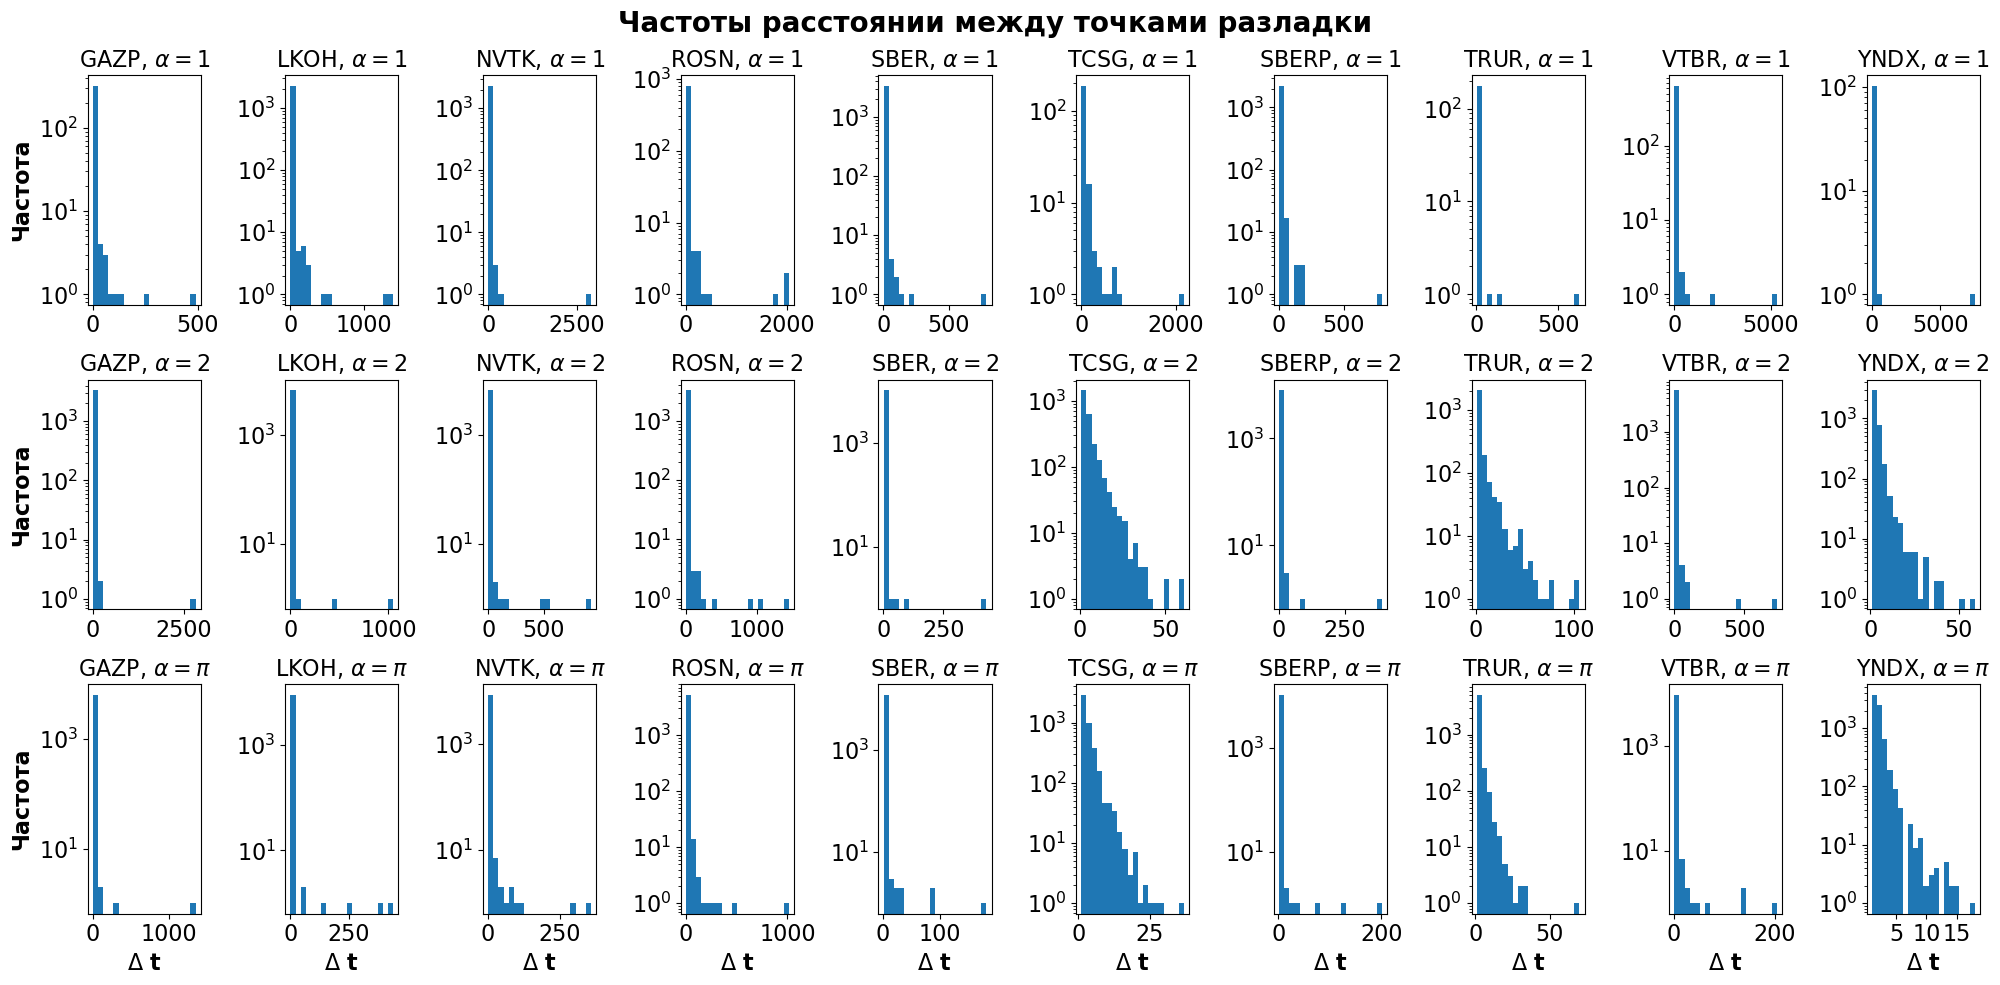

In [48]:
cpd_bns= CPD(method = "Binseg") 

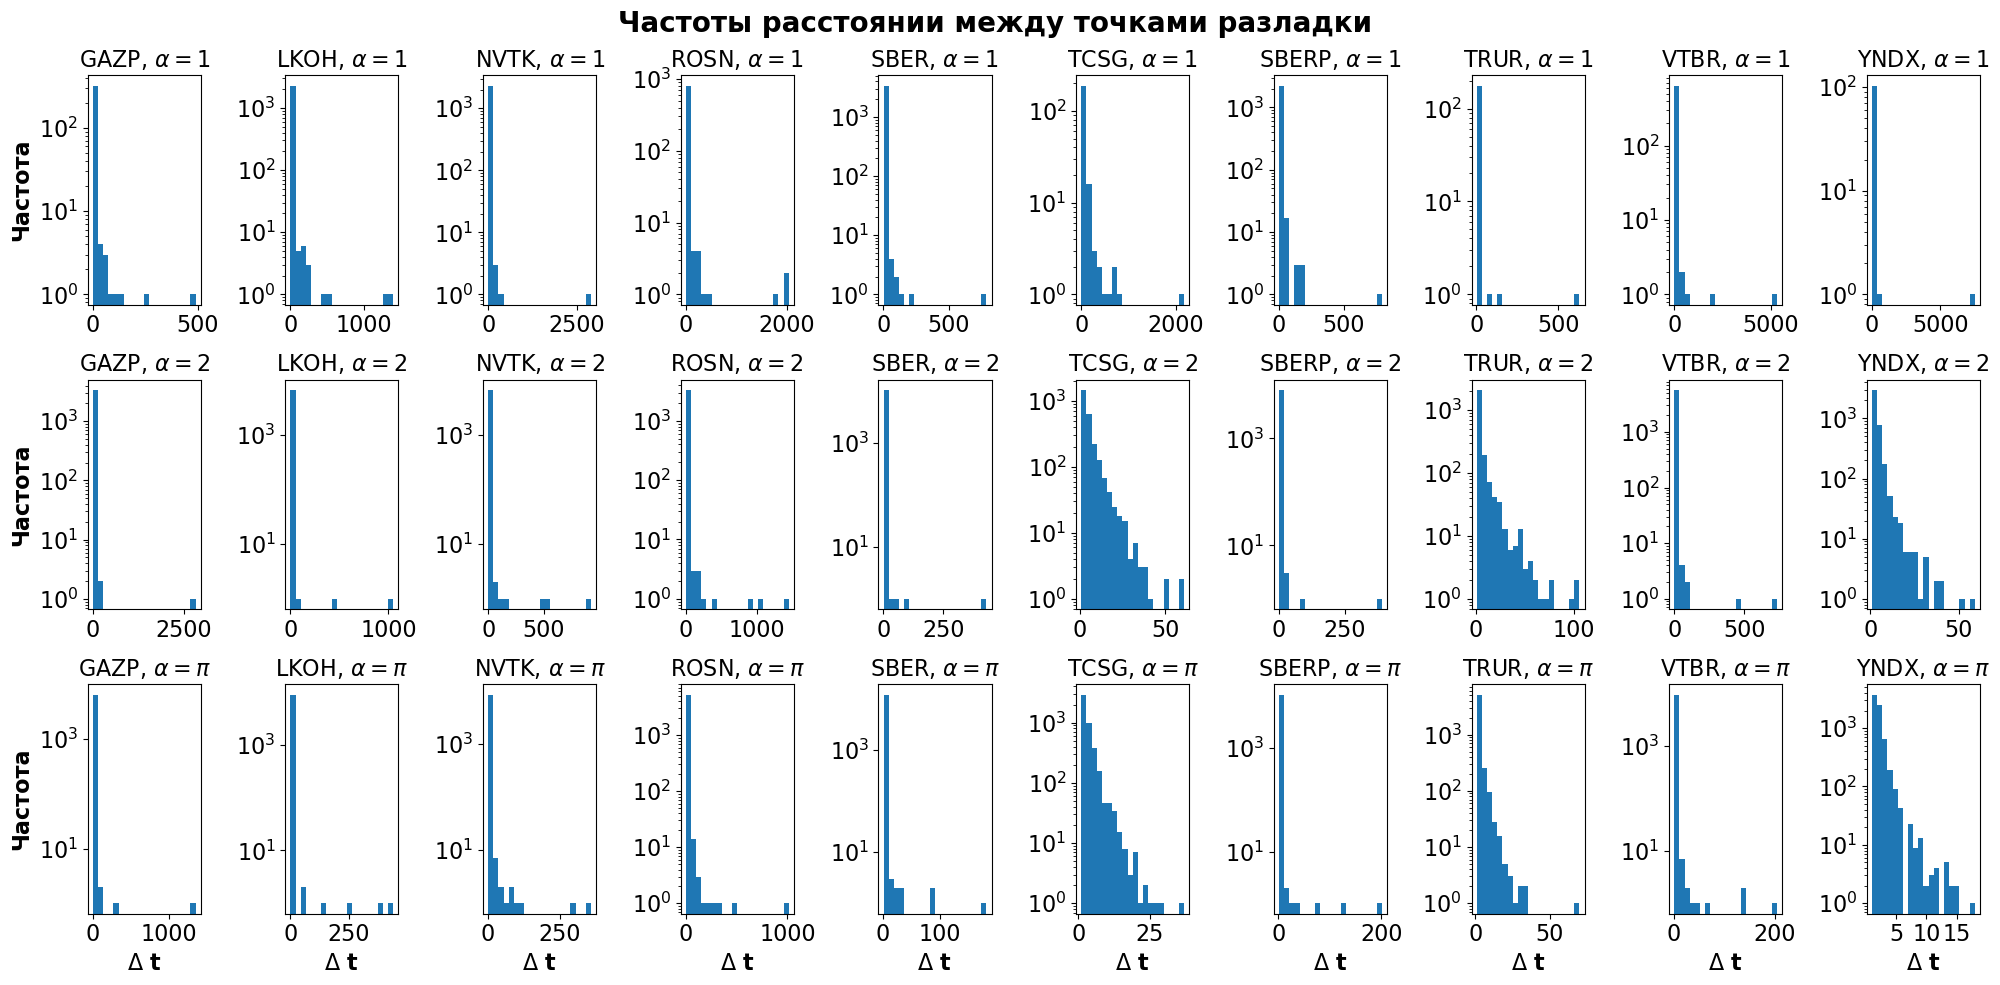

In [49]:
cpd_wnd= CPD(method = "Window") 

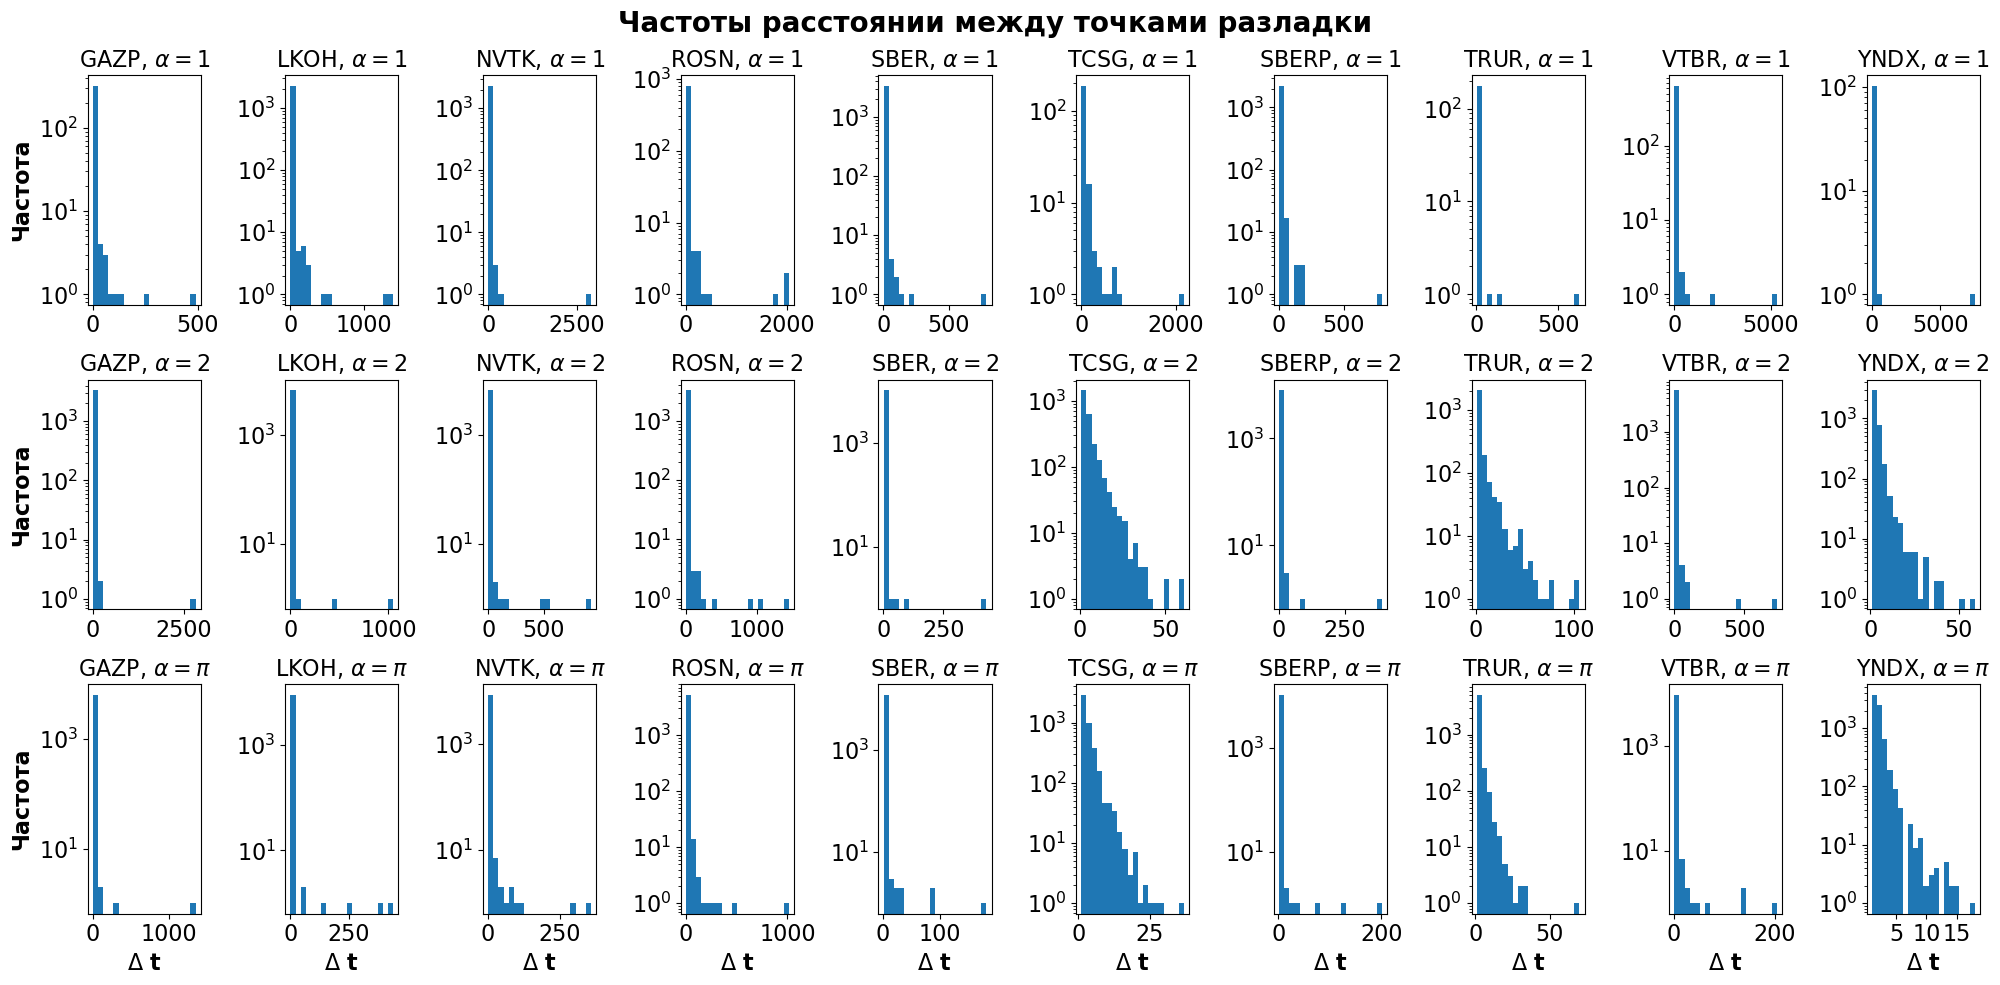

In [50]:
cpd_pelt= CPD(method = "Pelt") 

In [51]:
f1, acc, pr = cpd_bns.cpd_predict()

  0%|          | 0/30 [00:00<?, ?it/s]

GAZP, $\alpha = 1$:   0%|          | 0/12 [00:00<?, ?it/s]

[[0.75251069 0.56278028 0.32914908]
 [0.74756942 0.55810855 0.31553857]
 [0.73676964 0.54780526 0.29949788]
 [0.72908642 0.54057291 0.28626299]
 [0.71503557 0.52746766 0.26859408]]


GAZP, $\alpha = 2$:   0%|          | 0/12 [00:00<?, ?it/s]

[[0.55805515 0.52098009 0.46295076]
 [0.55645119 0.51913444 0.45945662]
 [0.54826205 0.51058226 0.44635717]
 [0.54366669 0.50549064 0.43959757]
 [0.54096896 0.50252247 0.43477827]]


GAZP, $\alpha = \pi$:   0%|          | 0/12 [00:00<?, ?it/s]

[[0.63912988 0.48372483 0.29368215]
 [0.63700866 0.48170502 0.29154917]
 [0.63362597 0.47856764 0.28859933]
 [0.63218745 0.4770138  0.28660226]
 [0.62993834 0.47418958 0.2823477 ]]


LKOH, $\alpha = 1$:   0%|          | 0/12 [00:00<?, ?it/s]

[[0.78694169 0.54306041 0.31026328]
 [0.77786745 0.53590153 0.28496205]
 [0.75110149 0.51192748 0.25243964]
 [0.73015915 0.49327482 0.23482079]
 [0.72494382 0.48861405 0.23006152]]


LKOH, $\alpha = 2$:   0%|          | 0/12 [00:00<?, ?it/s]

[[0.61319464 0.54544003 0.46552496]
 [0.60774254 0.53953795 0.45736537]
 [0.60188795 0.533367   0.45017573]
 [0.60030119 0.53170929 0.44836845]
 [0.59910377 0.53051907 0.44679192]]


LKOH, $\alpha = \pi$:   0%|          | 0/12 [00:00<?, ?it/s]

[[0.5861816  0.50442663 0.38886222]
 [0.58720403 0.50438828 0.3904307 ]
 [0.58579641 0.50278841 0.38861798]
 [0.58524591 0.50228459 0.38814814]
 [0.58423067 0.50140166 0.3874339 ]]


NVTK, $\alpha = 1$:   0%|          | 0/12 [00:00<?, ?it/s]

[[0.84583712 0.59547372 0.36032131]
 [0.82665465 0.58624492 0.309932  ]
 [0.80859866 0.57164914 0.28446574]
 [0.7811541  0.54788643 0.2645362 ]
 [0.77062248 0.53891719 0.25930367]]


NVTK, $\alpha = 2$:   0%|          | 0/12 [00:00<?, ?it/s]

[[0.57971522 0.53163831 0.4707743 ]
 [0.57128147 0.52268505 0.45054189]
 [0.55988859 0.51127183 0.43356484]
 [0.55681716 0.50807011 0.42933854]
 [0.55465688 0.50599082 0.42668218]]


NVTK, $\alpha = \pi$:   0%|          | 0/12 [00:00<?, ?it/s]

[[0.50963671 0.50630831 0.47696544]
 [0.50688803 0.50154026 0.47084532]
 [0.51357323 0.50303803 0.47798928]
 [0.51155228 0.50050179 0.47528872]
 [0.51090622 0.49994799 0.47498509]]


ROSN, $\alpha = 1$:   0%|          | 0/12 [00:00<?, ?it/s]

[[0.85421617 0.57185848 0.32400898]
 [0.83886022 0.56421195 0.28731654]
 [0.81036171 0.53906644 0.25510186]
 [0.79207914 0.52339833 0.23454902]
 [0.78325259 0.51595939 0.22276654]]


ROSN, $\alpha = 2$:   0%|          | 0/12 [00:00<?, ?it/s]

[[0.56412903 0.52492981 0.4689311 ]
 [0.553858   0.51116421 0.44771958]
 [0.54951647 0.50623165 0.44107732]
 [0.54449517 0.5010545  0.43336387]
 [0.54176352 0.49860383 0.42802999]]


ROSN, $\alpha = \pi$:   0%|          | 0/12 [00:00<?, ?it/s]

[[0.54473893 0.5111595  0.45297706]
 [0.53891309 0.50004332 0.43967069]
 [0.53570345 0.49659508 0.43552281]
 [0.53416607 0.49514996 0.43336336]
 [0.53143104 0.49269071 0.43027381]]


SBER, $\alpha = 1$:   0%|          | 0/12 [00:00<?, ?it/s]

[[0.69624138 0.53393206 0.36780622]
 [0.69325463 0.53133151 0.35849407]
 [0.67971311 0.51835367 0.34085877]
 [0.67024443 0.50991059 0.32447465]
 [0.65486784 0.49614873 0.30355735]]


SBER, $\alpha = 2$:   0%|          | 0/12 [00:00<?, ?it/s]

[[0.51945268 0.50035537 0.44453052]
 [0.51586973 0.49614904 0.43807875]
 [0.51344751 0.49323297 0.43316725]
 [0.50915528 0.48819448 0.42580727]
 [0.50136235 0.47893029 0.41380671]]


SBER, $\alpha = \pi$:   0%|          | 0/12 [00:00<?, ?it/s]

[[0.7422269  0.48310307 0.20580864]
 [0.74076351 0.48181566 0.20447779]
 [0.73899643 0.48025747 0.20302096]
 [0.73313268 0.47503413 0.19971839]
 [0.7301914  0.4724583  0.19765805]]


SBERP, $\alpha = 1$:   0%|          | 0/12 [00:00<?, ?it/s]

[[0.73178002 0.54785373 0.3707592 ]
 [0.72832459 0.54481784 0.35865297]
 [0.71049686 0.5279503  0.32940495]
 [0.69819947 0.51694198 0.30724924]
 [0.68233065 0.50257563 0.285792  ]]


SBERP, $\alpha = 2$:   0%|          | 0/12 [00:00<?, ?it/s]

[[0.50303344 0.52764895 0.55398426]
 [0.49973129 0.52355838 0.54735595]
 [0.49353501 0.51628666 0.53066583]
 [0.49070483 0.51280438 0.52590004]
 [0.4822867  0.50261351 0.51191917]]


SBERP, $\alpha = \pi$:   0%|          | 0/12 [00:00<?, ?it/s]

[[0.6971912  0.5037267  0.27228778]
 [0.69643985 0.50303969 0.27175173]
 [0.69537717 0.50208817 0.27062372]
 [0.68833951 0.49591646 0.26370097]
 [0.68501595 0.49293116 0.2615991 ]]


TCSG, $\alpha = 1$:   0%|          | 0/12 [00:00<?, ?it/s]

[[0.86240171 0.54493046 0.20554821]
 [0.85234535 0.53691942 0.18978093]
 [0.82363239 0.51183637 0.16257589]
 [0.80231929 0.4926388  0.15342056]
 [0.78109117 0.47419251 0.14594733]]


TCSG, $\alpha = 2$:   0%|          | 0/12 [00:00<?, ?it/s]

[[0.56684049 0.51483742 0.42046173]
 [0.55953131 0.50690937 0.40756261]
 [0.54675835 0.49258734 0.39384322]
 [0.54116764 0.48613022 0.39098762]
 [0.54091065 0.48586923 0.39069707]]


TCSG, $\alpha = \pi$:   0%|          | 0/12 [00:00<?, ?it/s]

[[0.51440131 0.52783628 0.54055597]
 [0.51440544 0.52652239 0.53939126]
 [0.51120276 0.52212202 0.53372122]
 [0.5110547  0.52191835 0.5334935 ]
 [0.51104239 0.52190329 0.5334752 ]]


TRUR, $\alpha = 1$:   0%|          | 0/12 [00:00<?, ?it/s]

[[0.88598927 0.54138513 0.38463352]
 [0.85205742 0.5261628  0.19861217]
 [0.8418037  0.51693054 0.1824788 ]
 [0.81758212 0.4948286  0.17280032]
 [0.80004048 0.47892283 0.15445145]]


TRUR, $\alpha = 2$:   0%|          | 0/12 [00:00<?, ?it/s]

[[0.62378329 0.5236391  0.40838763]
 [0.61185642 0.51143295 0.37556901]
 [0.5992903  0.49985398 0.35940181]
 [0.59036528 0.49120947 0.34765879]
 [0.58528585 0.48627517 0.34214317]]


TRUR, $\alpha = \pi$:   0%|          | 0/12 [00:00<?, ?it/s]

[[0.52926894 0.5177124  0.48990253]
 [0.53520089 0.52042274 0.49594167]
 [0.52892453 0.51290527 0.48619315]
 [0.52731715 0.51126144 0.48420914]
 [0.52633523 0.51025401 0.48308022]]


VTBR, $\alpha = 1$:   0%|          | 0/12 [00:00<?, ?it/s]

[[0.74851088 0.56926263 0.41158272]
 [0.74485785 0.56595728 0.39948878]
 [0.73507577 0.55701913 0.3755145 ]
 [0.72134846 0.54441732 0.34974375]
 [0.70998066 0.53391253 0.33216177]]


VTBR, $\alpha = 2$:   0%|          | 0/12 [00:00<?, ?it/s]

[[0.50970696 0.49767372 0.42597277]
 [0.50327929 0.48898459 0.42060778]
 [0.50045708 0.48590884 0.41587861]
 [0.49252064 0.47577228 0.40944202]
 [0.48658646 0.46933858 0.4010033 ]]


VTBR, $\alpha = \pi$:   0%|          | 0/12 [00:00<?, ?it/s]

[[0.65119717 0.51669171 0.34555395]
 [0.64472731 0.51074316 0.33756858]
 [0.6416271  0.50795276 0.33490406]
 [0.63996249 0.50649261 0.33350682]
 [0.63687621 0.50378668 0.33130098]]


YNDX, $\alpha = 1$:   0%|          | 0/12 [00:00<?, ?it/s]

[[0.91119347 0.57380897 0.24507562]
 [0.89809592 0.5632671  0.20660794]
 [0.86717665 0.55003495 0.19281204]
 [0.85248551 0.53731019 0.18353436]
 [0.84185247 0.52814772 0.17597757]]


YNDX, $\alpha = 2$:   0%|          | 0/12 [00:00<?, ?it/s]

[[0.55058259 0.534926   0.51717716]
 [0.54497121 0.52845509 0.50540915]
 [0.53658873 0.51880654 0.4919465 ]
 [0.53232229 0.5140293  0.48537496]
 [0.53212786 0.51372859 0.48499214]]


YNDX, $\alpha = \pi$:   0%|          | 0/12 [00:00<?, ?it/s]

[[0.48217879 0.51605624 0.54943792]
 [0.49017381 0.52061589 0.55550848]
 [0.48956431 0.51840948 0.55399174]
 [0.48937978 0.51818323 0.55370994]
 [0.48937978 0.51818323 0.55370994]]


TypeError: cannot unpack non-iterable NoneType object

In [52]:
f1, acc, pr = cpd_pelt.cpd_predict()

  0%|          | 0/30 [00:00<?, ?it/s]

GAZP, $\alpha = 1$:   0%|          | 0/12 [00:00<?, ?it/s]

[[0.75997357 0.56995565 0.33677354]
 [0.74754963 0.55800939 0.31899186]
 [0.73518359 0.54632804 0.29495846]
 [0.72118396 0.5330703  0.27596755]
 [0.70837069 0.52118645 0.26439935]]


GAZP, $\alpha = 2$:   0%|          | 0/12 [00:00<?, ?it/s]

[[0.56724634 0.53162513 0.48181293]
 [0.55733579 0.52020037 0.46125907]
 [0.54778613 0.51016442 0.44570892]
 [0.54210706 0.50382735 0.43657101]
 [0.5382014  0.49964096 0.42949974]]


GAZP, $\alpha = \pi$:   0%|          | 0/12 [00:00<?, ?it/s]

[[0.64214627 0.48661673 0.29562179]
 [0.63995111 0.48439387 0.29354727]
 [0.6335229  0.47834295 0.28803323]
 [0.63113984 0.47572382 0.28466093]
 [0.62880746 0.4726869  0.2802152 ]]


LKOH, $\alpha = 1$:   0%|          | 0/12 [00:00<?, ?it/s]

[[0.79078384 0.54633679 0.32700033]
 [0.78085788 0.5380471  0.293422  ]
 [0.75015202 0.51093126 0.25061488]
 [0.72850083 0.49167043 0.23070192]
 [0.72054525 0.4843219  0.22177303]]


LKOH, $\alpha = 2$:   0%|          | 0/12 [00:00<?, ?it/s]

[[0.61660333 0.54866037 0.4768468 ]
 [0.61233663 0.54460252 0.46380866]
 [0.60204024 0.53359864 0.4502736 ]
 [0.59914026 0.53055512 0.44684065]
 [0.59700905 0.52845196 0.44424658]]


LKOH, $\alpha = \pi$:   0%|          | 0/12 [00:00<?, ?it/s]

[[0.57913833 0.4959218  0.36587691]
 [0.58877027 0.50679144 0.39339307]
 [0.58573369 0.50277138 0.38869178]
 [0.58451613 0.50164967 0.38762776]
 [0.58339573 0.50067745 0.38689558]]


NVTK, $\alpha = 1$:   0%|          | 0/12 [00:00<?, ?it/s]

[[0.84717126 0.57766478 0.35312588]
 [0.83212444 0.57705423 0.30511843]
 [0.80880923 0.56529899 0.2732145 ]
 [0.7811213  0.54105879 0.25365251]
 [0.76642443 0.52787745 0.243271  ]]


NVTK, $\alpha = 2$:   0%|          | 0/12 [00:00<?, ?it/s]

[[0.56507874 0.52350892 0.45853787]
 [0.57629893 0.52887526 0.46548237]
 [0.56248588 0.51381727 0.43682833]
 [0.55642738 0.50766353 0.42861099]
 [0.5543514  0.50565097 0.42619508]]


NVTK, $\alpha = \pi$:   0%|          | 0/12 [00:00<?, ?it/s]

[[0.50756866 0.5144786  0.49070155]
 [0.51176345 0.50959345 0.48214328]
 [0.51342918 0.50294055 0.47806445]
 [0.51155889 0.50079196 0.47558794]
 [0.51097858 0.50029447 0.47532019]]


ROSN, $\alpha = 1$:   0%|          | 0/12 [00:00<?, ?it/s]

[[0.85604333 0.57182285 0.32869184]
 [0.8448214  0.56451679 0.28525934]
 [0.81259515 0.54089851 0.25136262]
 [0.78779053 0.51982911 0.22292363]
 [0.77737735 0.51086388 0.21180817]]


ROSN, $\alpha = 2$:   0%|          | 0/12 [00:00<?, ?it/s]

[[0.57895351 0.54460163 0.50893502]
 [0.56811338 0.53243263 0.48160039]
 [0.54969005 0.50670607 0.4398477 ]
 [0.54309405 0.50000965 0.42964103]
 [0.53856399 0.49591827 0.423975  ]]


ROSN, $\alpha = \pi$:   0%|          | 0/12 [00:00<?, ?it/s]

[[0.5473304  0.51539824 0.45548624]
 [0.5385782  0.50060798 0.43696953]
 [0.53220807 0.49337344 0.42983081]
 [0.52979519 0.49108786 0.42695156]
 [0.52715923 0.48870499 0.42447426]]


SBER, $\alpha = 1$:   0%|          | 0/12 [00:00<?, ?it/s]

[[0.70251906 0.53841441 0.37990282]
 [0.69183671 0.52833156 0.35366147]
 [0.67969255 0.51714452 0.33166905]
 [0.66124487 0.50004386 0.30746636]
 [0.64183622 0.48242354 0.28841118]]


SBER, $\alpha = 2$:   0%|          | 0/12 [00:00<?, ?it/s]

[[0.5282623  0.51256832 0.45997288]
 [0.51997057 0.50107032 0.44570281]
 [0.51365066 0.49359608 0.43352072]
 [0.50571524 0.48430515 0.4205831 ]
 [0.50105131 0.47869098 0.41342982]]


SBER, $\alpha = \pi$:   0%|          | 0/12 [00:00<?, ?it/s]

[[0.74432588 0.48499416 0.20714564]
 [0.7421451  0.48302619 0.20586884]
 [0.73891246 0.48018059 0.20310621]
 [0.73177372 0.47384266 0.19878324]
 [0.73085828 0.47304105 0.19810369]]


SBERP, $\alpha = 1$:   0%|          | 0/12 [00:00<?, ?it/s]

[[0.73469376 0.55075817 0.37923813]
 [0.72450262 0.54154064 0.3473809 ]
 [0.70915398 0.5271149  0.31978205]
 [0.68870486 0.50831472 0.29417422]
 [0.67059599 0.49208846 0.27362755]]


SBERP, $\alpha = 2$:   0%|          | 0/12 [00:00<?, ?it/s]

[[0.50316201 0.52780719 0.55428516]
 [0.50285875 0.52744027 0.55357481]
 [0.49409827 0.51695872 0.53184411]
 [0.48709168 0.50846555 0.51925897]
 [0.48115467 0.50126939 0.51019014]]


SBERP, $\alpha = \pi$:   0%|          | 0/12 [00:00<?, ?it/s]

[[0.69934405 0.50559488 0.27508015]
 [0.6971912  0.5037267  0.27228778]
 [0.69472141 0.50151447 0.27002937]
 [0.68620311 0.49398135 0.26255173]
 [0.68495984 0.49288108 0.26155171]]


TCSG, $\alpha = 1$:   0%|          | 0/12 [00:00<?, ?it/s]

[[0.87031276 0.54867947 0.2344526 ]
 [0.85683388 0.53745395 0.20503141]
 [0.82981141 0.51526577 0.16425584]
 [0.799362   0.48790693 0.15011719]
 [0.78179987 0.47264191 0.14366744]]


TCSG, $\alpha = 2$:   0%|          | 0/12 [00:00<?, ?it/s]

[[0.57713587 0.52683019 0.44700615]
 [0.57317906 0.52181953 0.43412537]
 [0.55170787 0.49790986 0.40075937]
 [0.54290706 0.48813841 0.39393495]
 [0.5425034  0.48773172 0.39349851]]


TCSG, $\alpha = \pi$:   0%|          | 0/12 [00:00<?, ?it/s]

[[0.50996263 0.53039074 0.5428694 ]
 [0.51110096 0.52726004 0.53858485]
 [0.51304221 0.52455263 0.53688545]
 [0.51272135 0.52394915 0.53631233]
 [0.5126106  0.5238136  0.53614698]]


TRUR, $\alpha = 1$:   0%|          | 0/12 [00:00<?, ?it/s]

[[0.88263474 0.53094625 0.36218165]
 [0.85125383 0.52576682 0.1909508 ]
 [0.83829891 0.51372641 0.17897708]
 [0.81764477 0.49459859 0.16586233]
 [0.7872474  0.46760536 0.15167367]]


TRUR, $\alpha = 2$:   0%|          | 0/12 [00:00<?, ?it/s]

[[0.6249129  0.52940616 0.44293565]
 [0.62265979 0.52278296 0.39899124]
 [0.6032335  0.50357127 0.36572208]
 [0.58917494 0.49010198 0.34628623]
 [0.58571374 0.48669067 0.34264359]]


TRUR, $\alpha = \pi$:   0%|          | 0/12 [00:00<?, ?it/s]

[[0.53204781 0.52784854 0.50623038]
 [0.529381   0.52103526 0.49292822]
 [0.5307607  0.51483869 0.48863183]
 [0.5289291  0.51284239 0.48608012]
 [0.52665735 0.51057127 0.48341795]]


VTBR, $\alpha = 1$:   0%|          | 0/12 [00:00<?, ?it/s]

[[0.7582612  0.57800348 0.44508959]
 [0.74240499 0.56378452 0.38979378]
 [0.73327153 0.55545918 0.36686875]
 [0.71344813 0.53723562 0.33310948]
 [0.69837801 0.52343074 0.3137611 ]]


VTBR, $\alpha = 2$:   0%|          | 0/12 [00:00<?, ?it/s]

[[0.51082182 0.49900438 0.42846608]
 [0.50365066 0.48935688 0.42080553]
 [0.49492267 0.47831948 0.41192866]
 [0.48805354 0.47087707 0.40259064]
 [0.48327029 0.46548921 0.39599208]]


VTBR, $\alpha = \pi$:   0%|          | 0/12 [00:00<?, ?it/s]

[[0.65117306 0.5166069  0.34545813]
 [0.64679984 0.51263028 0.33955113]
 [0.64116212 0.50753903 0.33468852]
 [0.63766508 0.5044765  0.33182665]
 [0.63596737 0.50295932 0.33058639]]


YNDX, $\alpha = 1$:   0%|          | 0/12 [00:00<?, ?it/s]

[[0.91968606 0.58002931 0.26996695]
 [0.90723713 0.57009383 0.22150302]
 [0.87230861 0.5545136  0.18929791]
 [0.84786603 0.53317317 0.17697563]
 [0.83351625 0.52049275 0.17362168]]


YNDX, $\alpha = 2$:   0%|          | 0/12 [00:00<?, ?it/s]

[[0.56236644 0.55091269 0.56711642]
 [0.54598377 0.53231682 0.51491032]
 [0.5373827  0.52052442 0.49445137]
 [0.52936284 0.51167102 0.48138687]
 [0.53067026 0.51256824 0.48306324]]


YNDX, $\alpha = \pi$:   0%|          | 0/12 [00:00<?, ?it/s]

[[0.47819802 0.51893953 0.55084401]
 [0.48516853 0.51975731 0.55177462]
 [0.48804367 0.51733745 0.55210151]
 [0.48791937 0.51712838 0.55189146]
 [0.48791937 0.51712838 0.55189146]]


TypeError: cannot unpack non-iterable NoneType object

In [53]:
f1, acc, pr = cpd_wnd.cpd_predict()

  0%|          | 0/30 [00:00<?, ?it/s]

GAZP, $\alpha = 1$:   0%|          | 0/12 [00:00<?, ?it/s]

[[0.79215209 0.50141854 0.46316533]
 [0.79211043 0.5014102  0.379832  ]
 [0.79192877 0.50122167 0.37526339]
 [0.79058728 0.49991046 0.32341875]
 [0.79353453 0.50261829 0.41517021]]


GAZP, $\alpha = 2$:   0%|          | 0/12 [00:00<?, ?it/s]

[[0.58219166 0.50016928 0.49970902]
 [0.58211564 0.50012158 0.49783975]
 [0.58179919 0.4998823  0.4758898 ]
 [0.58228729 0.50023611 0.49982086]
 [0.58129564 0.4994135  0.45596197]]


GAZP, $\alpha = \pi$:   0%|          | 0/12 [00:00<?, ?it/s]

[[0.70345951 0.49853879 0.33365116]
 [0.70339993 0.49847278 0.3300193 ]
 [0.7034579  0.49850173 0.33458577]
 [0.70403685 0.49894456 0.35575112]
 [0.70391163 0.49886086 0.35154142]]


LKOH, $\alpha = 1$:   0%|          | 0/12 [00:00<?, ?it/s]

[[0.80762375 0.50557692 0.4315686 ]
 [0.80763492 0.5056185  0.434131  ]
 [0.8073762  0.50501442 0.42044599]
 [0.80787319 0.50524349 0.42892888]
 [0.80335606 0.500048   0.2964448 ]]


LKOH, $\alpha = 2$:   0%|          | 0/12 [00:00<?, ?it/s]

[[0.63002368 0.501968   0.51834484]
 [0.63024883 0.50214435 0.52599135]
 [0.62960534 0.50156488 0.49589647]
 [0.62980037 0.50172609 0.50272059]
 [0.62886141 0.50099349 0.47064211]]


LKOH, $\alpha = \pi$:   0%|          | 0/12 [00:00<?, ?it/s]

[[0.63989899 0.49901096 0.39231544]
 [0.64094951 0.49987025 0.43437185]
 [0.64108122 0.49992063 0.43759718]
 [0.64085405 0.49974631 0.43031616]
 [0.64108122 0.49992063 0.43759718]]


NVTK, $\alpha = 1$:   0%|          | 0/12 [00:00<?, ?it/s]

[[0.85833382 0.5061248  0.34571998]
 [0.85823358 0.50603905 0.34097948]
 [0.85789038 0.50482861 0.32889166]
 [0.857436   0.50443824 0.30643253]
 [0.85651602 0.49883066 0.27030232]]


NVTK, $\alpha = 2$:   0%|          | 0/12 [00:00<?, ?it/s]

[[0.61124497 0.49939972 0.43337719]
 [0.6111899  0.49934671 0.43112004]
 [0.61134409 0.49947842 0.43428066]
 [0.61115152 0.49932056 0.4297663 ]
 [0.61228489 0.50030709 0.46632813]]


NVTK, $\alpha = \pi$:   0%|          | 0/12 [00:00<?, ?it/s]

[[0.549154   0.49948927 0.47440122]
 [0.54811395 0.49870802 0.43249342]
 [0.54789881 0.49854877 0.42722716]
 [0.54733905 0.49802739 0.41206391]
 [0.54757149 0.4982054  0.41830523]]


ROSN, $\alpha = 1$:   0%|          | 0/12 [00:00<?, ?it/s]

[[0.86611947 0.50423694 0.39214036]
 [0.86632465 0.50479678 0.38411437]
 [0.86705627 0.50605415 0.40276246]
 [0.86810353 0.50769058 0.44397477]
 [0.86663884 0.50528751 0.38736572]]


ROSN, $\alpha = 2$:   0%|          | 0/12 [00:00<?, ?it/s]

[[0.59426059 0.49872168 0.4193369 ]
 [0.59417632 0.49861784 0.41517023]
 [0.59439243 0.49878702 0.42277448]
 [0.59822195 0.5018262  0.53886053]
 [0.5974287  0.5011701  0.50887101]]


ROSN, $\alpha = \pi$:   0%|          | 0/12 [00:00<?, ?it/s]

[[0.58506643 0.49926388 0.4396655 ]
 [0.58463539 0.49894059 0.42726558]
 [0.58589478 0.49991384 0.46236433]
 [0.58637318 0.50028913 0.47641013]
 [0.58815622 0.50183047 0.53173291]]


SBER, $\alpha = 1$:   0%|          | 0/12 [00:00<?, ?it/s]

[[0.71253705 0.49981686 0.38965339]
 [0.71234383 0.49966268 0.379696  ]
 [0.71163895 0.49912806 0.34864197]
 [0.71182027 0.499242   0.36417827]
 [0.71155151 0.4990611  0.34446071]]


SBER, $\alpha = 2$:   0%|          | 0/12 [00:00<?, ?it/s]

[[0.5618818  0.49813822 0.3912043 ]
 [0.56192719 0.49821634 0.39327442]
 [0.5620766  0.49835921 0.39948453]
 [0.56276113 0.4988864  0.42438543]
 [0.56264144 0.49884731 0.42298657]]


SBER, $\alpha = \pi$:   0%|          | 0/12 [00:00<?, ?it/s]

[[0.83961637 0.49889688 0.25918634]
 [0.83961637 0.49889688 0.25918634]
 [0.83961637 0.49889688 0.25918634]
 [0.8393848  0.49863731 0.24976345]
 [0.8396331  0.49891354 0.25918634]]


SBERP, $\alpha = 1$:   0%|          | 0/12 [00:00<?, ?it/s]

[[0.74961417 0.50150672 0.41132121]
 [0.74912849 0.50097044 0.39184117]
 [0.748767   0.50060578 0.37805884]
 [0.74839732 0.50022802 0.363619  ]
 [0.74852286 0.50042059 0.40432336]]


SBERP, $\alpha = 2$:   0%|          | 0/12 [00:00<?, ?it/s]

[[0.4910724  0.49880079 0.5012209 ]
 [0.4910724  0.49880079 0.5012209 ]
 [0.49138557 0.49906647 0.51548152]
 [0.49093257 0.49872208 0.49407188]
 [0.49164754 0.4992796  0.51986975]]


SBERP, $\alpha = \pi$:   0%|          | 0/12 [00:00<?, ?it/s]

[[0.77335504 0.499227   0.30852052]
 [0.77335504 0.499227   0.30852052]
 [0.77324231 0.49911013 0.30119714]
 [0.77320367 0.4990745  0.30001636]
 [0.77268001 0.49851136 0.28566788]]


TCSG, $\alpha = 1$:   0%|          | 0/12 [00:00<?, ?it/s]

[[0.90873895 0.50540034 0.28290114]
 [0.90880308 0.5061494  0.28703711]
 [0.90829104 0.50428431 0.26869464]
 [0.90800262 0.50280673 0.25615736]
 [0.90751861 0.50113987 0.23786171]]


TCSG, $\alpha = 2$:   0%|          | 0/12 [00:00<?, ?it/s]

[[0.60581027 0.50158141 0.51197706]
 [0.60577269 0.50155581 0.51146028]
 [0.60498751 0.50092212 0.48629162]
 [0.60769956 0.50315481 0.57281096]
 [0.60607863 0.50193424 0.53477344]]


TCSG, $\alpha = \pi$:   0%|          | 0/12 [00:00<?, ?it/s]

[[0.5062581  0.50220934 0.6247579 ]
 [0.50634754 0.50227676 0.62706164]
 [0.50635598 0.50229159 0.62951428]
 [0.50654371 0.50244101 0.63826399]
 [0.50556054 0.50170136 0.60975141]]


TRUR, $\alpha = 1$:   0%|          | 0/12 [00:00<?, ?it/s]

[[0.87869584 0.49966416 0.32758805]
 [0.87867917 0.4996475  0.32758805]
 [0.8786875  0.49965583 0.32758805]
 [0.8786875  0.49965583 0.32758805]
 [0.87866249 0.49963083 0.32758805]]


TRUR, $\alpha = 2$:   0%|          | 0/12 [00:00<?, ?it/s]

[[0.70617172 0.49962884 0.45495248]
 [0.70570752 0.49922807 0.43942681]
 [0.70570752 0.49922807 0.43942681]
 [0.70576198 0.4992781  0.44161132]
 [0.7063294  0.49979171 0.46148372]]


TRUR, $\alpha = \pi$:   0%|          | 0/12 [00:00<?, ?it/s]

[[0.60326466 0.50007139 0.5421691 ]
 [0.60334559 0.50012198 0.54427904]
 [0.60330126 0.50008861 0.54283337]
 [0.60486016 0.50152374 0.61239854]
 [0.60483127 0.50152265 0.61252256]]


VTBR, $\alpha = 1$:   0%|          | 0/12 [00:00<?, ?it/s]

[[0.77263982 0.5018246  0.39348333]
 [0.77229896 0.50113704 0.37637588]
 [0.77218477 0.50079373 0.3645104 ]
 [0.77197472 0.50022839 0.34770856]
 [0.77174145 0.50010412 0.34047194]]


VTBR, $\alpha = 2$:   0%|          | 0/12 [00:00<?, ?it/s]

[[0.55444992 0.50071403 0.52103381]
 [0.55430829 0.50061877 0.51386301]
 [0.55409284 0.50044852 0.50414199]
 [0.55452959 0.50076378 0.52236053]
 [0.55555606 0.50157871 0.56545144]]


VTBR, $\alpha = \pi$:   0%|          | 0/12 [00:00<?, ?it/s]

[[0.7246574  0.49903788 0.33921546]
 [0.72457173 0.49894163 0.32760934]
 [0.72430975 0.49863707 0.31656553]
 [0.72438732 0.49872059 0.32760934]
 [0.72444972 0.4987829  0.3311479 ]]


YNDX, $\alpha = 1$:   0%|          | 0/12 [00:00<?, ?it/s]

[[0.950679   0.51838843 0.29565825]
 [0.95066078 0.5183716  0.29309415]
 [0.95038278 0.51641823 0.27527011]
 [0.9492137  0.50286616 0.22941124]
 [0.94902997 0.49940226 0.20674907]]


YNDX, $\alpha = 2$:   0%|          | 0/12 [00:00<?, ?it/s]

[[0.55220968 0.50208468 0.58823539]
 [0.55213055 0.50203594 0.58646893]
 [0.55181326 0.50177553 0.57717691]
 [0.54948933 0.50007374 0.50542468]
 [0.55091724 0.50107898 0.55096094]]


YNDX, $\alpha = \pi$:   0%|          | 0/12 [00:00<?, ?it/s]

[[0.47372368 0.49905135 0.53143033]
 [0.47359498 0.49894878 0.52724552]
 [0.47372556 0.49902858 0.53139938]
 [0.47426555 0.4994528  0.55012588]
 [0.4781296  0.50246711 0.66718374]]


TypeError: cannot unpack non-iterable NoneType object

In [ ]:
# v,e = list(zip(*[(1,4),(2,5),(3,6)]))
# print(np.array(v).T)
# print(np.array(e).T)

In [65]:
def get_val(s):
    match = re.match(r"([\d.]+) ± ([\d.]+)", s)
    if match:
        return float(match[1]), float(match[2])
    return np.nan, np.nan

def metric_data(df):
    categories = df.iloc[:, 0]
    horizons = df.columns[1:]
    values, errors = [], []
    for col in horizons:
        # values - список кортежей, zip(* - пример выше
        v, e = zip(*df[col].apply(lambda x: get_val(x) if isinstance(x, str) else (np.nan, np.nan)))
        values.append(v)
        errors.append(e)
    return categories, horizons.astype(int), np.array(values).T, np.array(errors).T

category_styles = {
    "GAZP": ("crimson", ["o", "^", "s"], ['-', '--', ':']),       
    "LKOH": ("royalblue", ["o", "^", "s"], ['-', '--', ':']),      
    "NVTK": ("mediumseagreen", ["o", "^", "s"], ['-', '--', ':']), 
    "SBERP": ("darkblue", ["o", "^", "s"], ['-', '--', ':']),
    "ROSN": ("darkviolet", ["o", "^", "s"], ['-', '--', ':']),       
    "SBER": ("darkorange", ["o", "^", "s"], ['-', '--', ':']),      
    "TCSG": ("olivedrab", ["o", "^", "s"], ['-', '--', ':']),
    "TRUR": ("sienna", ["o", "^", "s"], ['-', '--', ':']),
    "VTBR": ("dimgrey", ["o", "^", "s"], ['-', '--', ':']),
    "YNDX": ("deeppink", ["o", "^", "s"], ['-', '--', ':'])
}

def plot_metrics(ax, categories, horizons, values, errors, category_styles, metric_name, title):
    for idx, mdl in enumerate(categories):
        color, marker, linestyle = None, None, None
        for style_key in category_styles:
            if style_key in mdl:
                color, markers, linestyle = category_styles[style_key]
                marker = markers[idx % len(markers)]
                linestyle = linestyle[idx % len(linestyle)] 
                break

        ax.errorbar(
            horizons, values[idx], yerr=errors[idx], fmt=marker, color=color,
            markersize=8, capsize=5, linestyle=linestyle, label=mdl  
        )

#     ax.hlines(0.1941, 1, 25, alpha=0.5, linewidth=5, linestyle='--', label='Случ. Классиф-ор')
#     ax.set_xscale('log')
#     ax.set_yscale('log')
    ax.set_xticks(horizons)
    ax.tick_params(labelsize=16)
    ax.get_xaxis().set_major_formatter(tck.ScalarFormatter())
    ax.set_xlabel('Горизонт предсказаний', fontsize=14, weight='bold')
    ax.set_ylabel(metric_name, fontsize=16, weight='bold')
    ax.set_title(title, fontsize=20, weight='bold')

## Binseg

In [66]:
bns_pr = pd.read_csv('Binseg_pr.csv')
bns_f1 = pd.read_csv('Binseg_f1.csv')
bns_acc = pd.read_csv('Binseg_acc.csv')

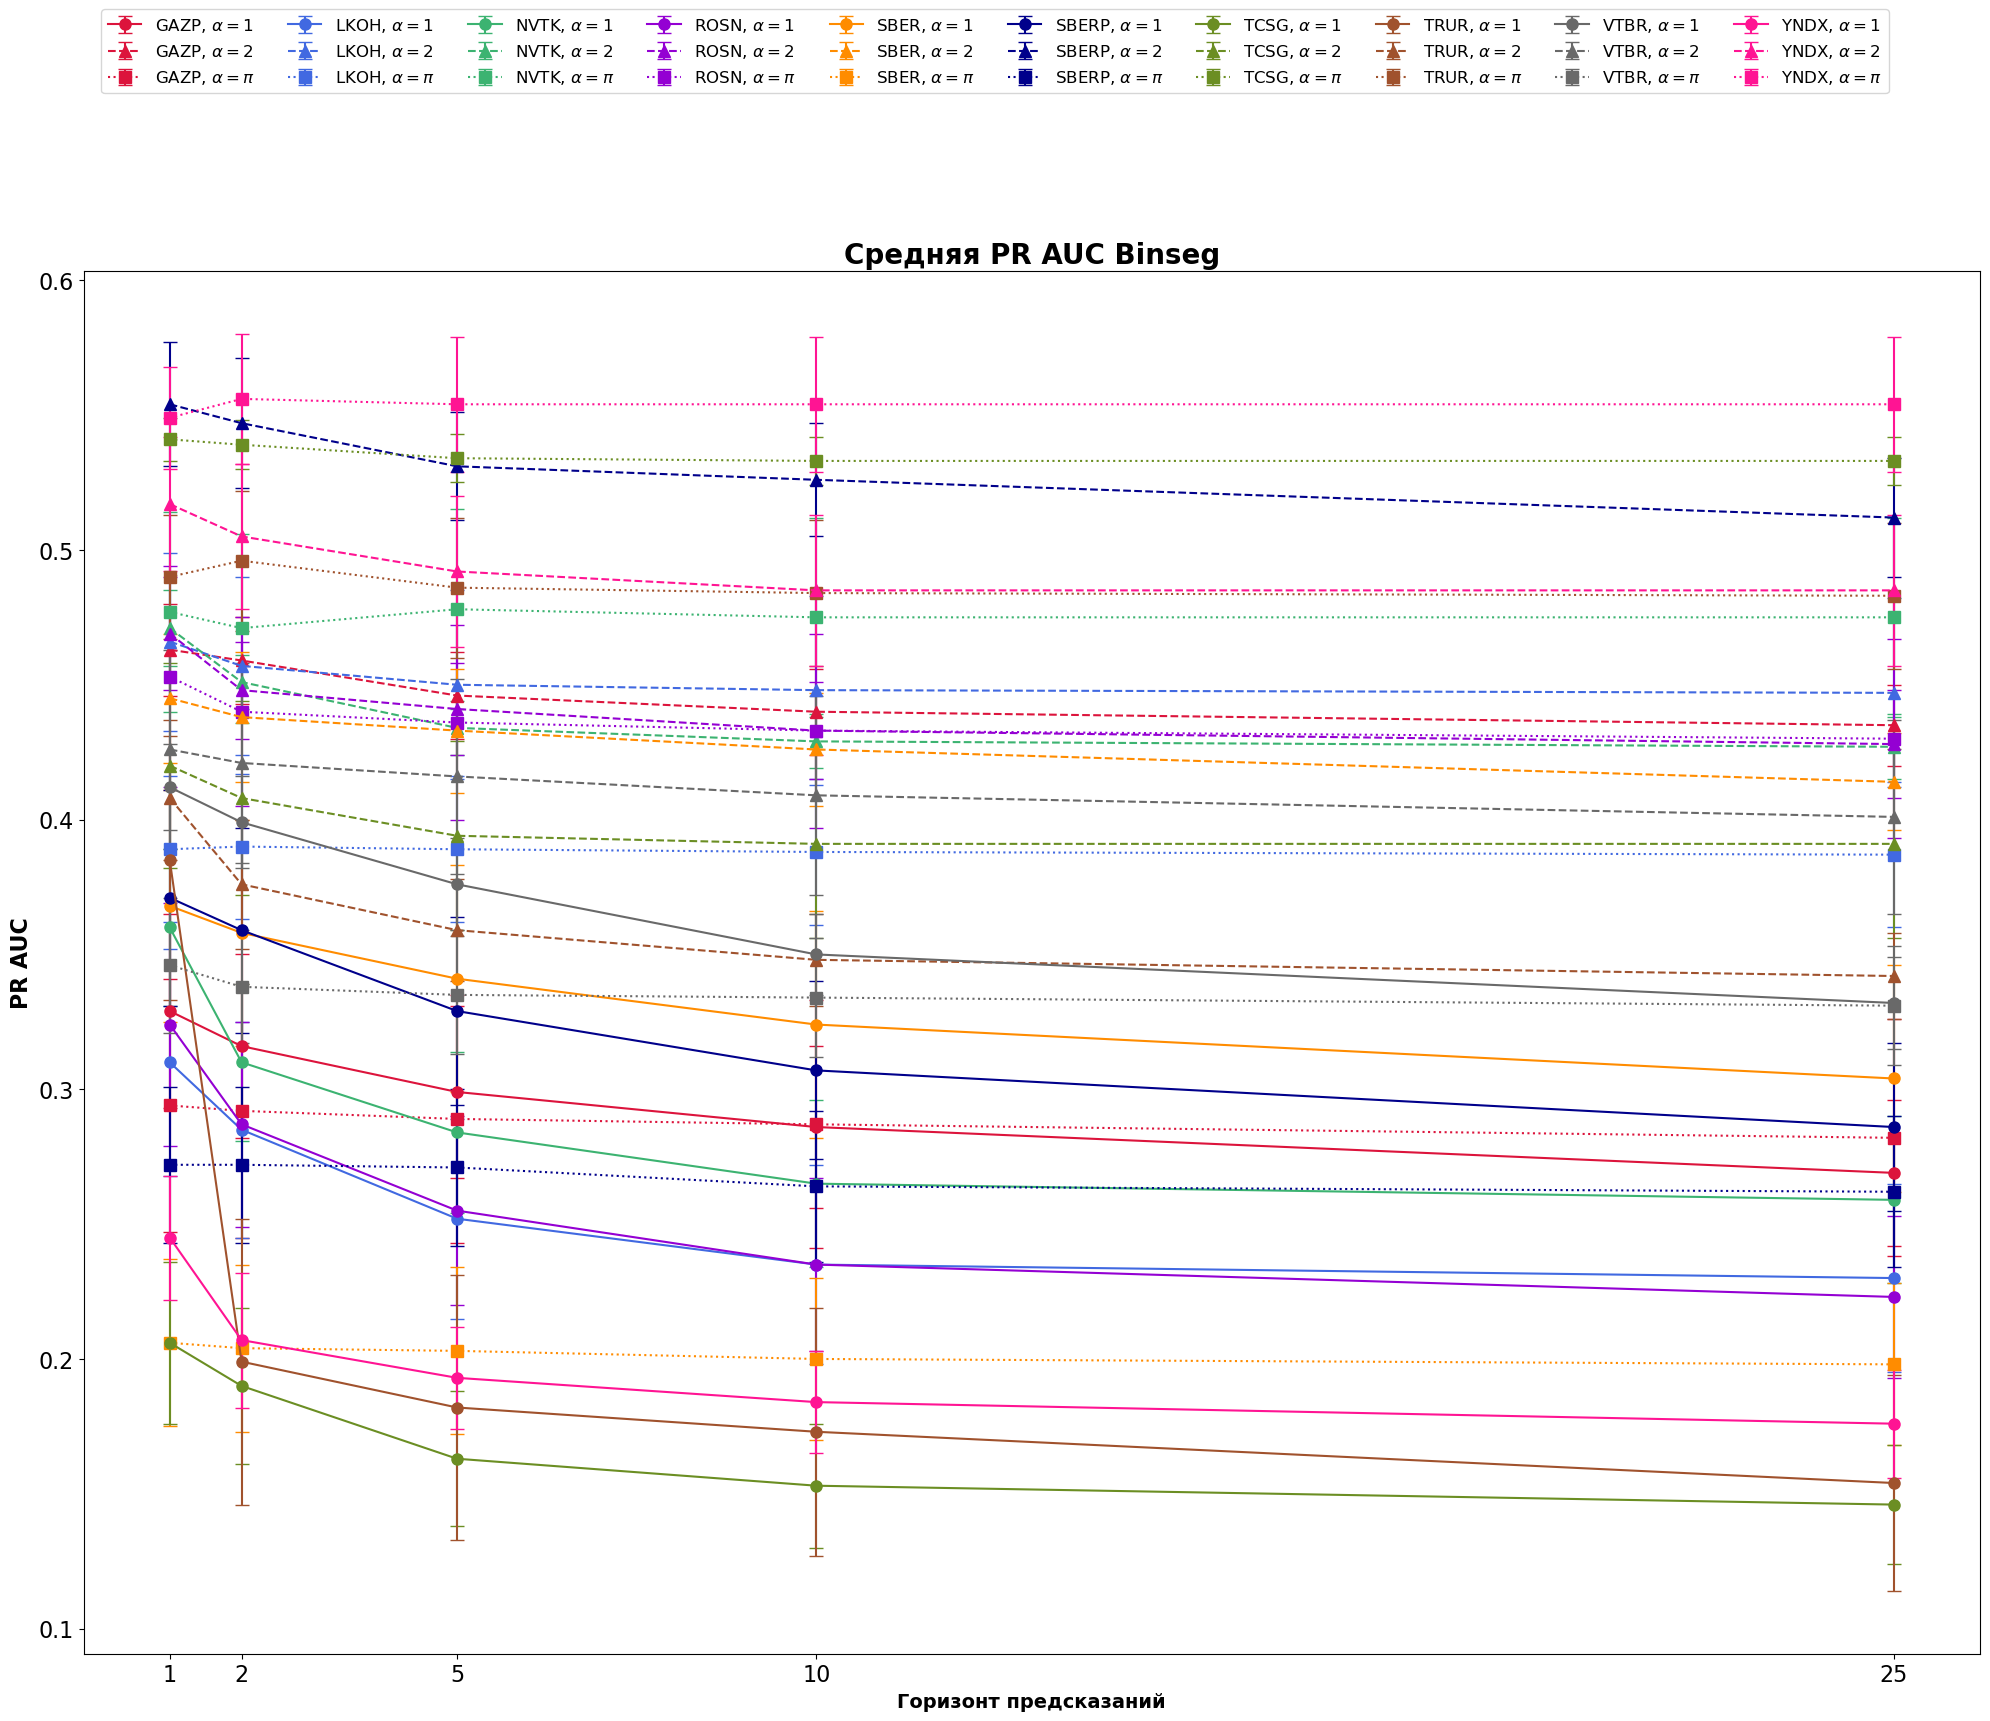

In [67]:
fig, ax = plt.subplots(ncols=1, figsize=(20, 15))

# PR
categories, horizons, values, errors = metric_data(bns_pr)
plot_metrics(ax, categories, horizons, values, errors, category_styles, 'PR AUC', 'Средняя PR AUC Binseg')

# F1
# categories_1, horizons_1, values_1, errors_1 = metric_data(bns_f1)
# plot_metrics(ax[1], categories_1, horizons_1, values_1, errors_1, category_styles, 'F1 AUC', 'Средняя F1 AUC Binseg')

# ACC 
# categories_2, horizons_2, values_2, errors_2 = metric_data(bns_acc)
# plot_metrics(ax[2], categories_2, horizons_2, values_2, errors_2, category_styles, 'ACC AUC', 'Средняя ACC AUC Binseg')

# легенда
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=10, fontsize=12)

plt.tight_layout()
plt.show()
fig.savefig('quality_metrics_Binseg.jpeg', format='jpeg', dpi=200, bbox_inches='tight')

## Pelt

In [69]:
plt_pr = pd.read_csv('Pelt_pr.csv')
plt_f1 = pd.read_csv('Pelt_f1.csv')
plt_acc = pd.read_csv('Pelt_acc.csv')

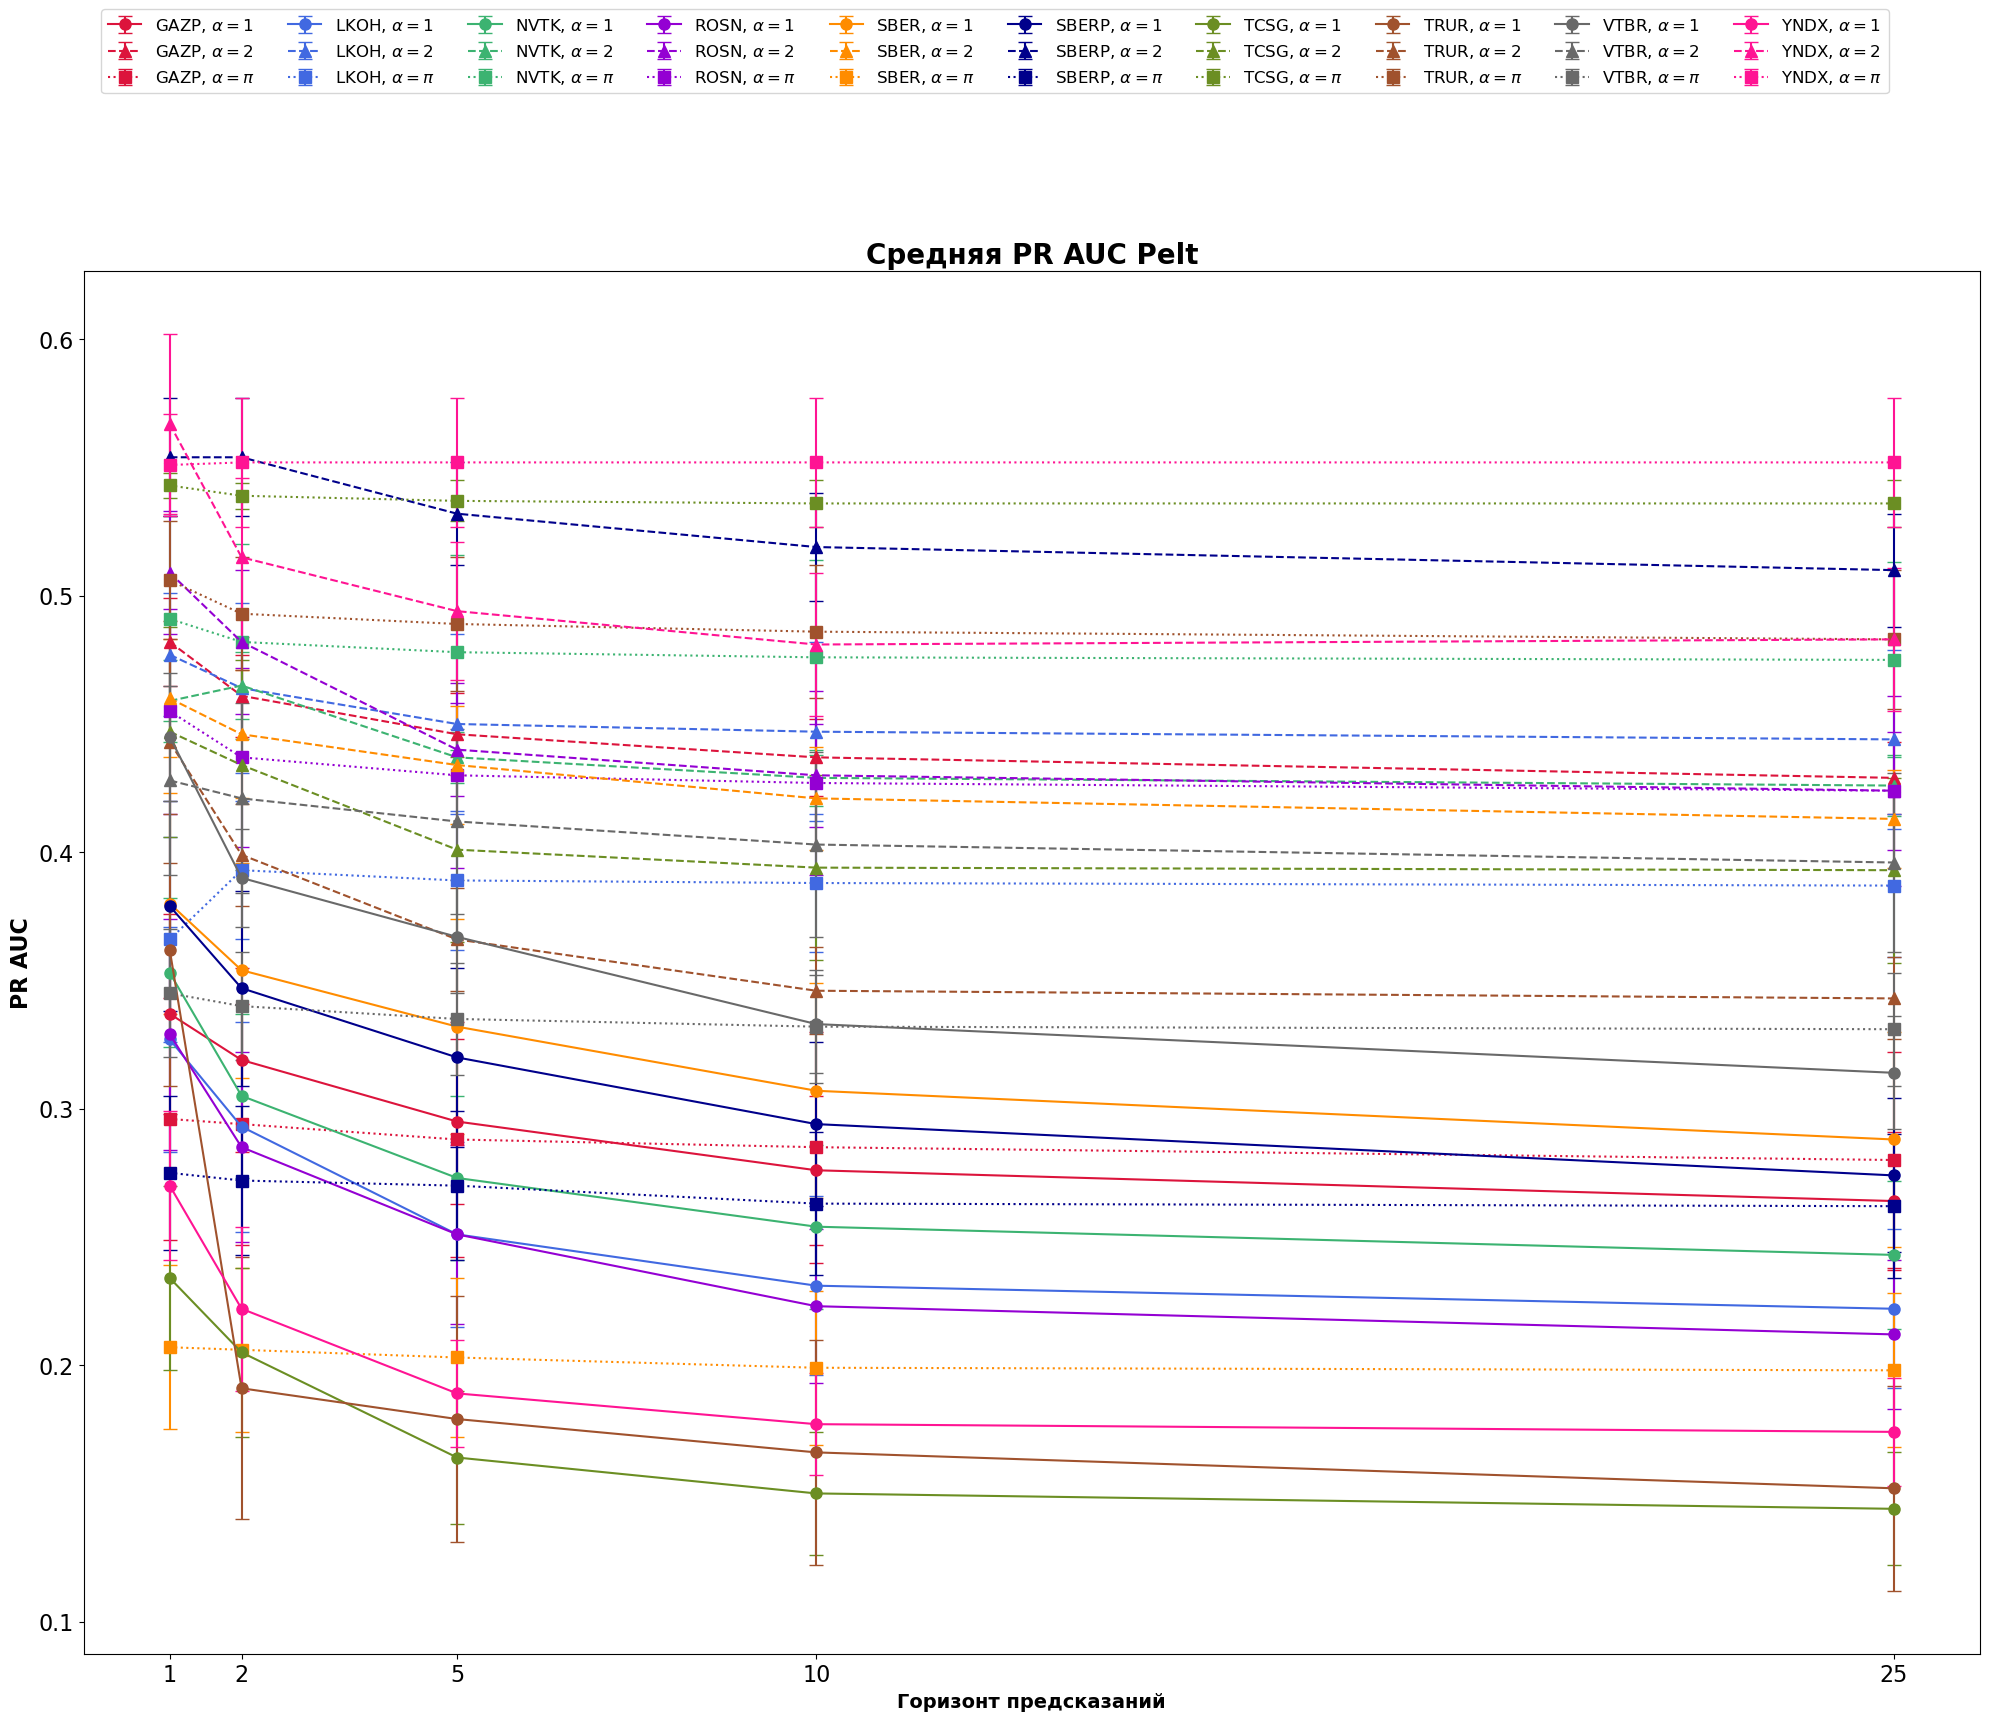

In [70]:
fig, ax = plt.subplots(ncols=1, figsize=(20, 15))

# PR
categories_m0, horizons_m0, values_m0, errors_m0 = metric_data(plt_pr)
plot_metrics(ax, categories_m0, horizons_m0, values_m0, errors_m0, category_styles, 'PR AUC', 'Средняя PR AUC Pelt')

# F1
# categories_m1, horizons_m1, values_m1, errors_m1 = metric_data(plt_f1)
# plot_metrics(ax[1], categories_m1, horizons_m1, values_m1, errors_m1, category_styles, 'F1 AUC', 'Средняя F1 AUC Pelt')

# ACC
# categories_m2, horizons_m2, values_m2, errors_m2 = metric_data(plt_acc)
# plot_metrics(ax[2], categories_m2, horizons_m2, values_m2, errors_m2, category_styles, 'ACC AUC', 'Средняя ACC AUC Pelt')

# легенда
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=10, fontsize=12)

plt.tight_layout()
plt.show()
fig.savefig('quality_metrics_MLP.jpeg', format='jpeg', dpi=200, bbox_inches='tight')

## Window

In [76]:
wnd_pr = pd.read_csv('Window_pr.csv')
wnd_f1 = pd.read_csv('Window_f1.csv')
wnd_acc = pd.read_csv('Window_acc.csv')

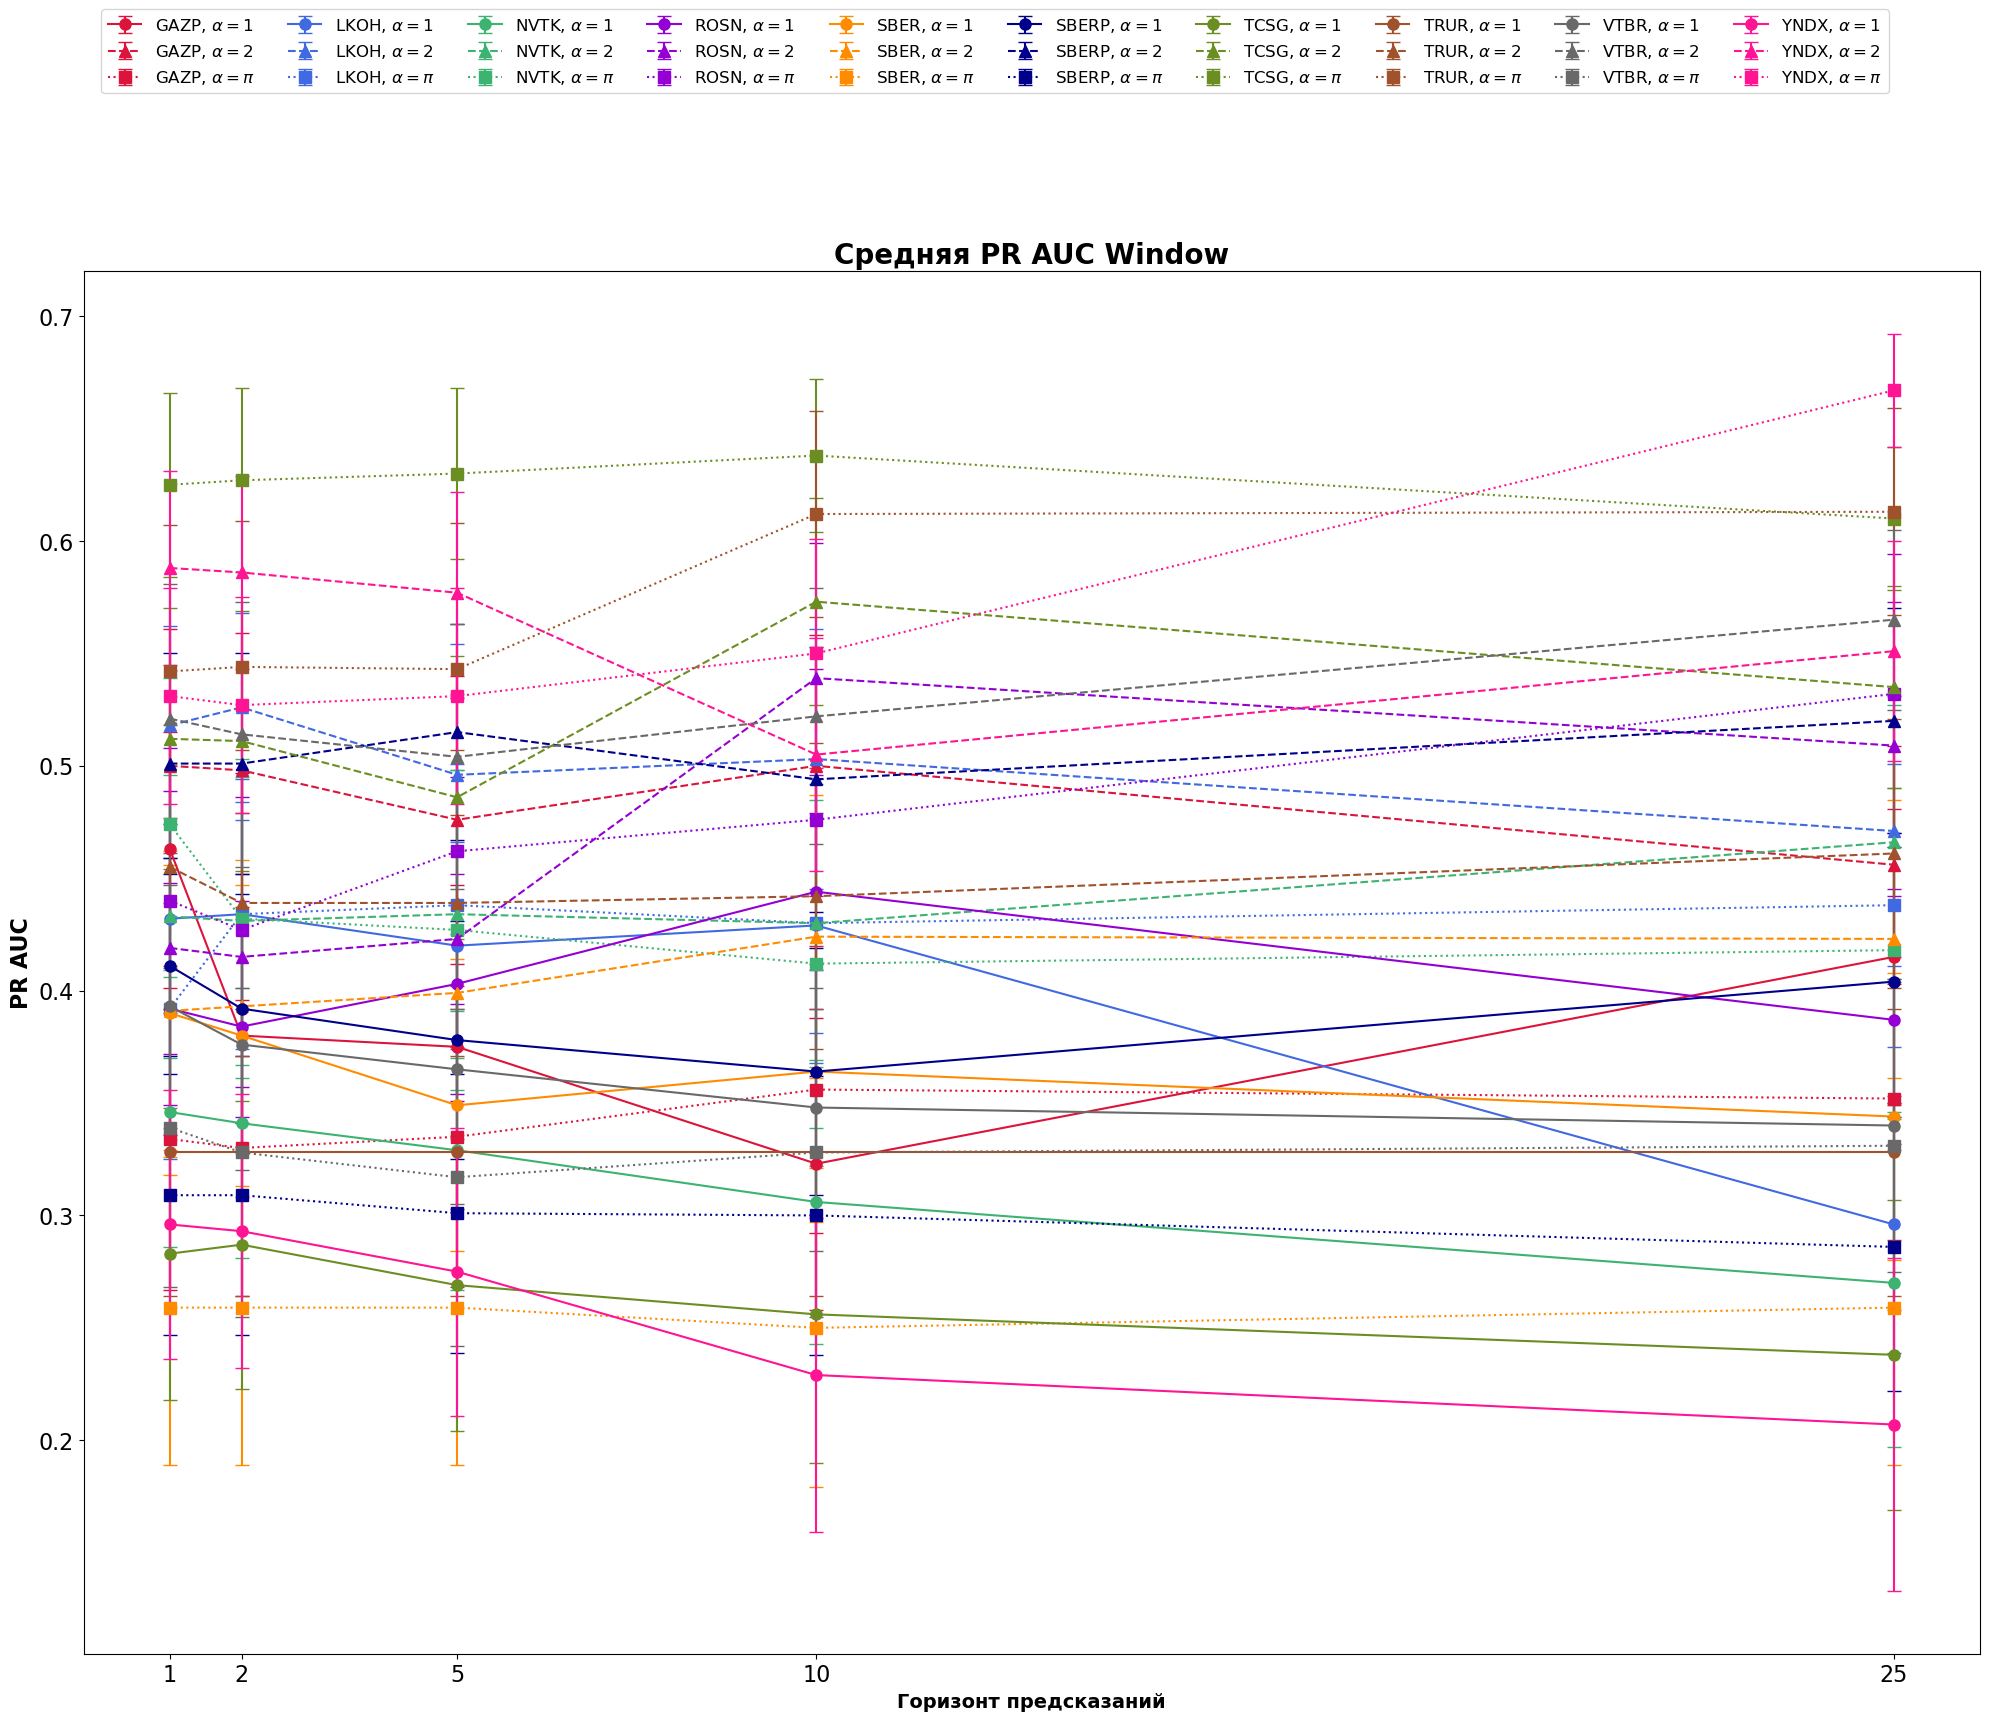

In [79]:
fig, ax = plt.subplots(ncols=1, figsize=(20, 15))

# PR
categories_m0, horizons_m0, values_m0, errors_m0 = metric_data(wnd_pr)
plot_metrics(ax, categories_m0, horizons_m0, values_m0, errors_m0, category_styles, 'PR AUC', 'Средняя PR AUC Window')

# F1
# categories_m1, horizons_m1, values_m1, errors_m1 = metric_data(wnd_f1)
# plot_metrics(ax[1], categories_m1, horizons_m1, values_m1, errors_m1, category_styles, 'F1 AUC', 'Средняя F1 AUC Window')

# ACC
# categories_m2, horizons_m2, values_m2, errors_m2 = metric_data(wnd_acc)
# plot_metrics(ax[2], categories_m2, horizons_m2, values_m2, errors_m2, category_styles, 'ACC AUC', 'Средняя ACC AUC Window')

# легенда
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=10, fontsize=12)

plt.tight_layout()
plt.show()
fig.savefig('quality_metrics_MLP.jpeg', format='jpeg', dpi=200, bbox_inches='tight')

In [54]:
df_bns = results_to_csv(cpd_bns, "binseg_cpd_results.csv")
df_pelt = results_to_csv(cpd_pelt, "pelt_cpd_results.csv")
df_wnd = results_to_csv(cpd_wnd, "window_cpd_results.csv")

df_all = pd.concat([df_bns, df_pelt, df_wnd], ignore_index=True)
df_all.to_csv("all_models_cpd_results_MOEX.csv", index=False)

In [56]:
all1 = pd.read_csv("all_models_cpd_results_MOEX.csv")
all1

,noise_type,alpha,model,horizon,metric_name,metric_value
0,GAZP,1,Binseg,1,f1,0.753 ± 0.033
1,GAZP,1,Binseg,2,f1,0.748 ± 0.034
2,GAZP,1,Binseg,5,f1,0.737 ± 0.035
3,GAZP,1,Binseg,10,f1,0.729 ± 0.036
4,GAZP,1,Binseg,25,f1,0.715 ± 0.038
...,...,...,...,...,...,...
1345,YNDX,\pi,Window,1,pr,0.531 ± 0.048
1346,YNDX,\pi,Window,2,pr,0.527 ± 0.048
1347,YNDX,\pi,Window,5,pr,0.531 ± 0.048
1348,YNDX,\pi,Window,10,pr,0.550 ± 0.051


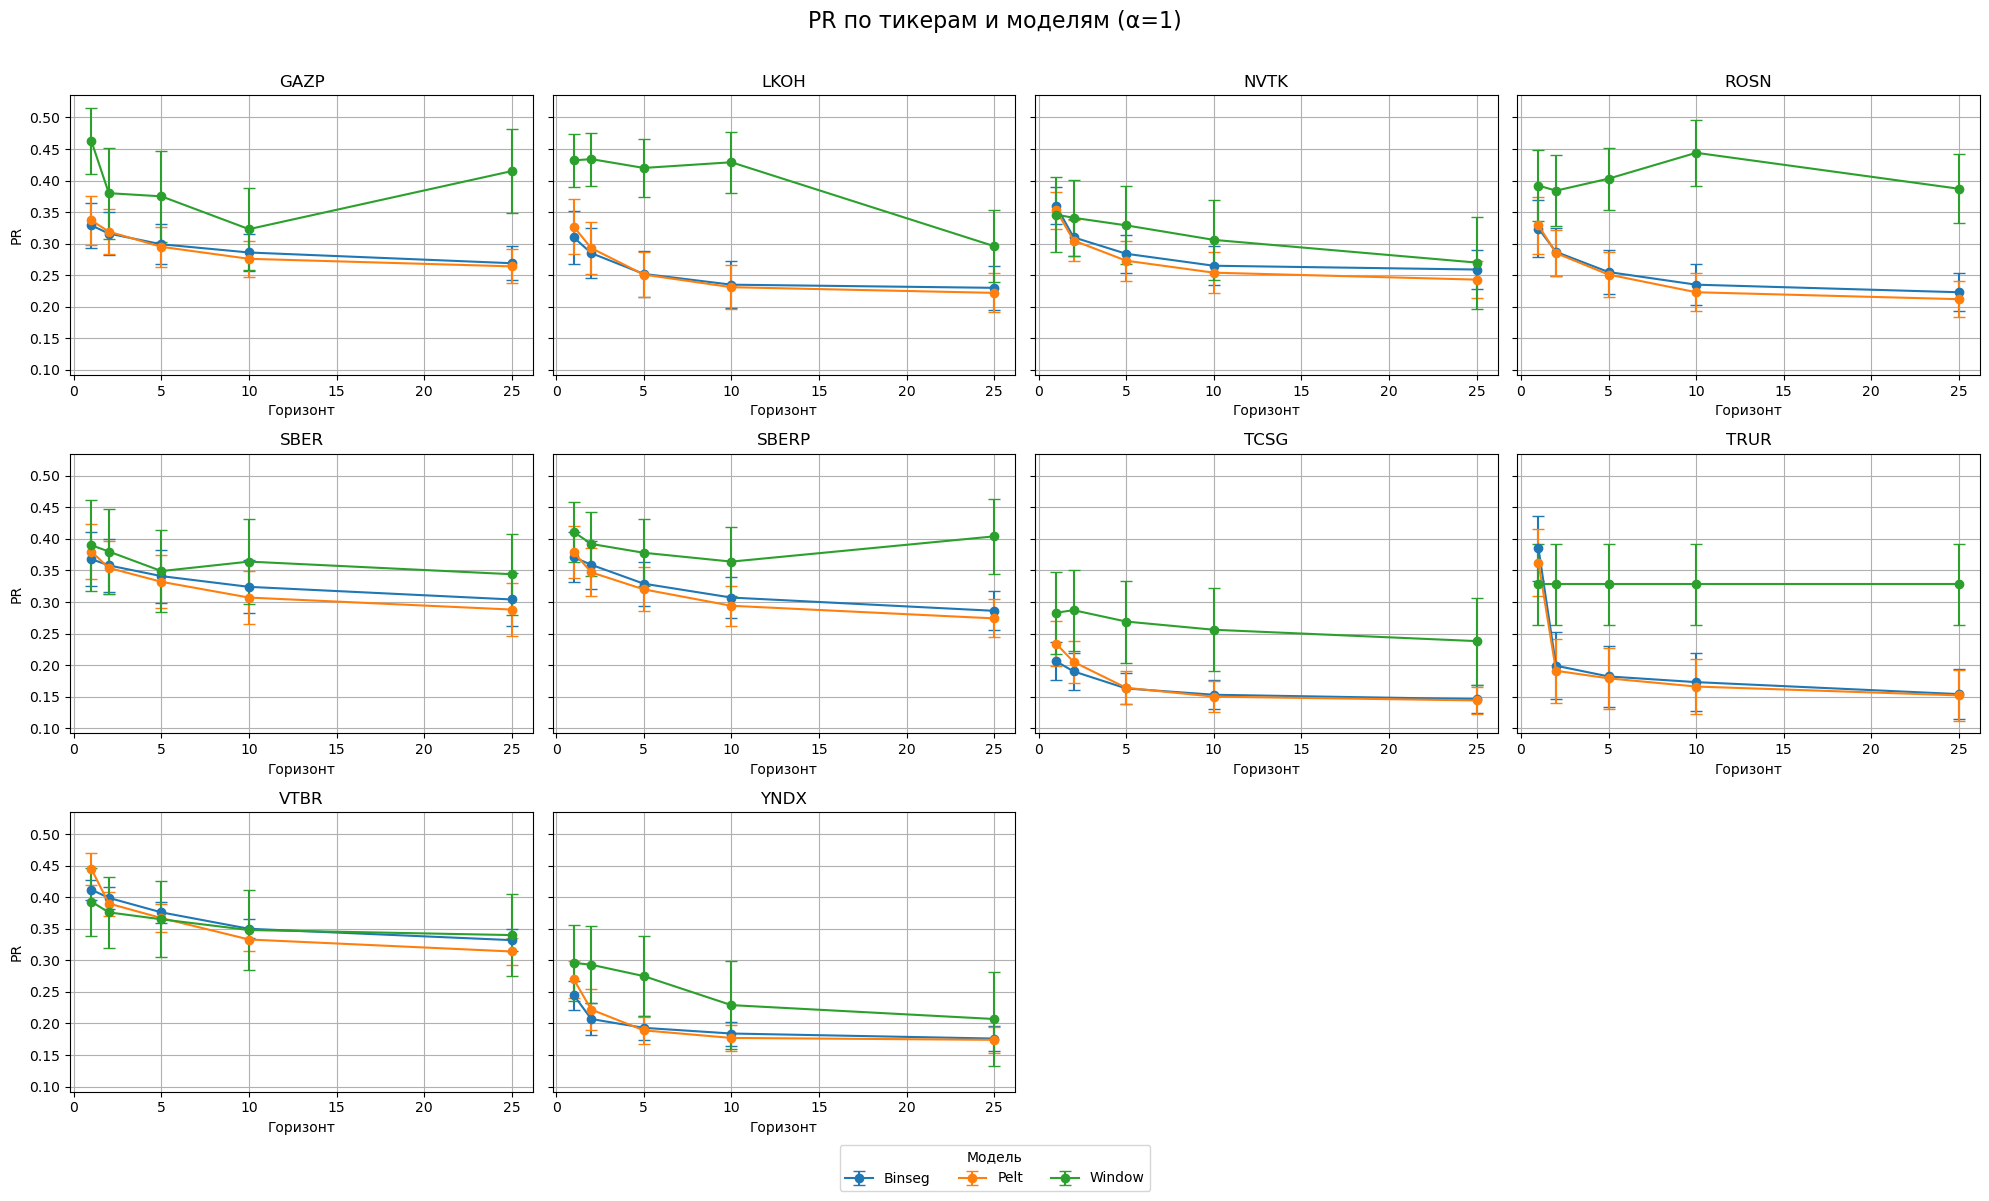

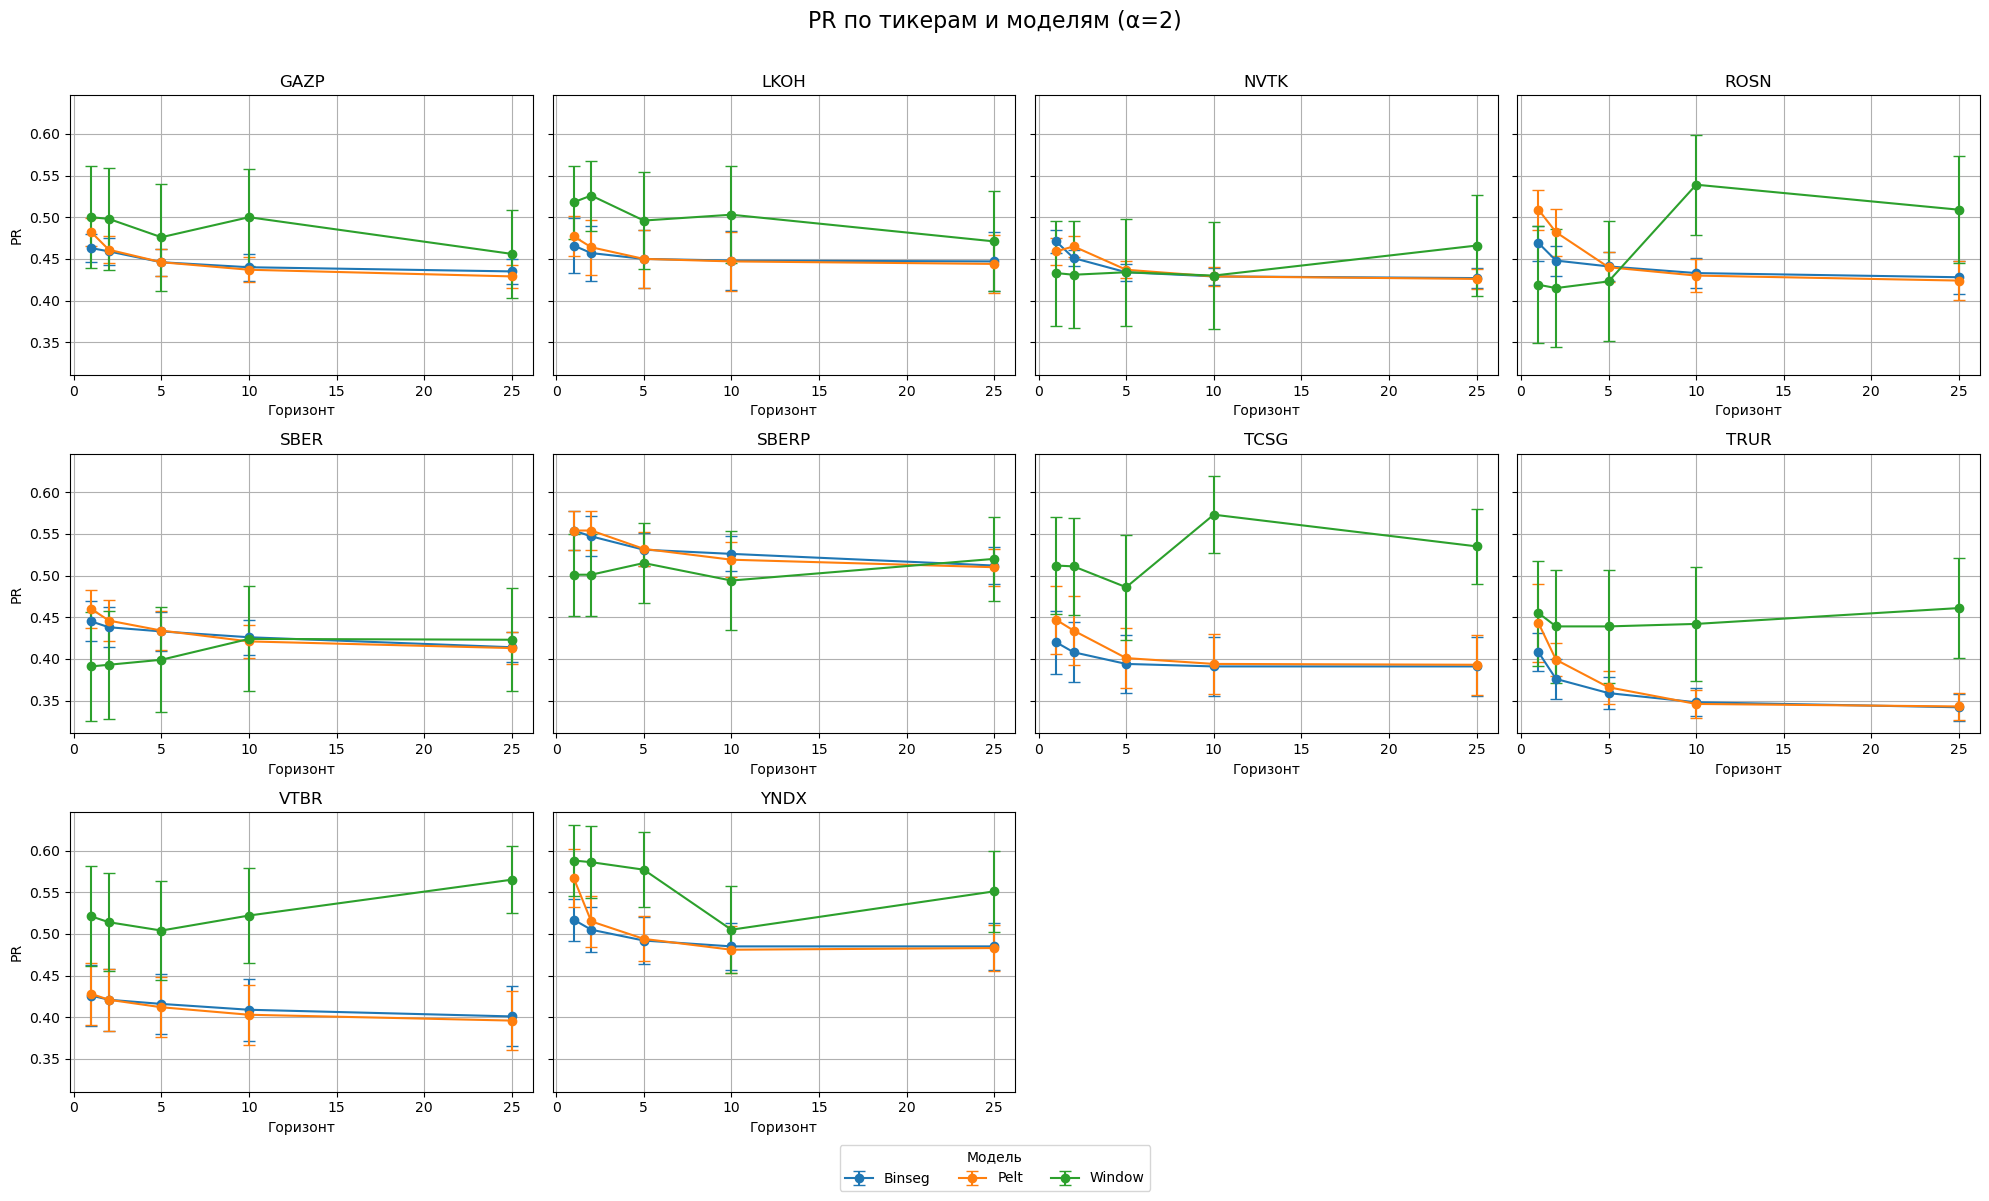

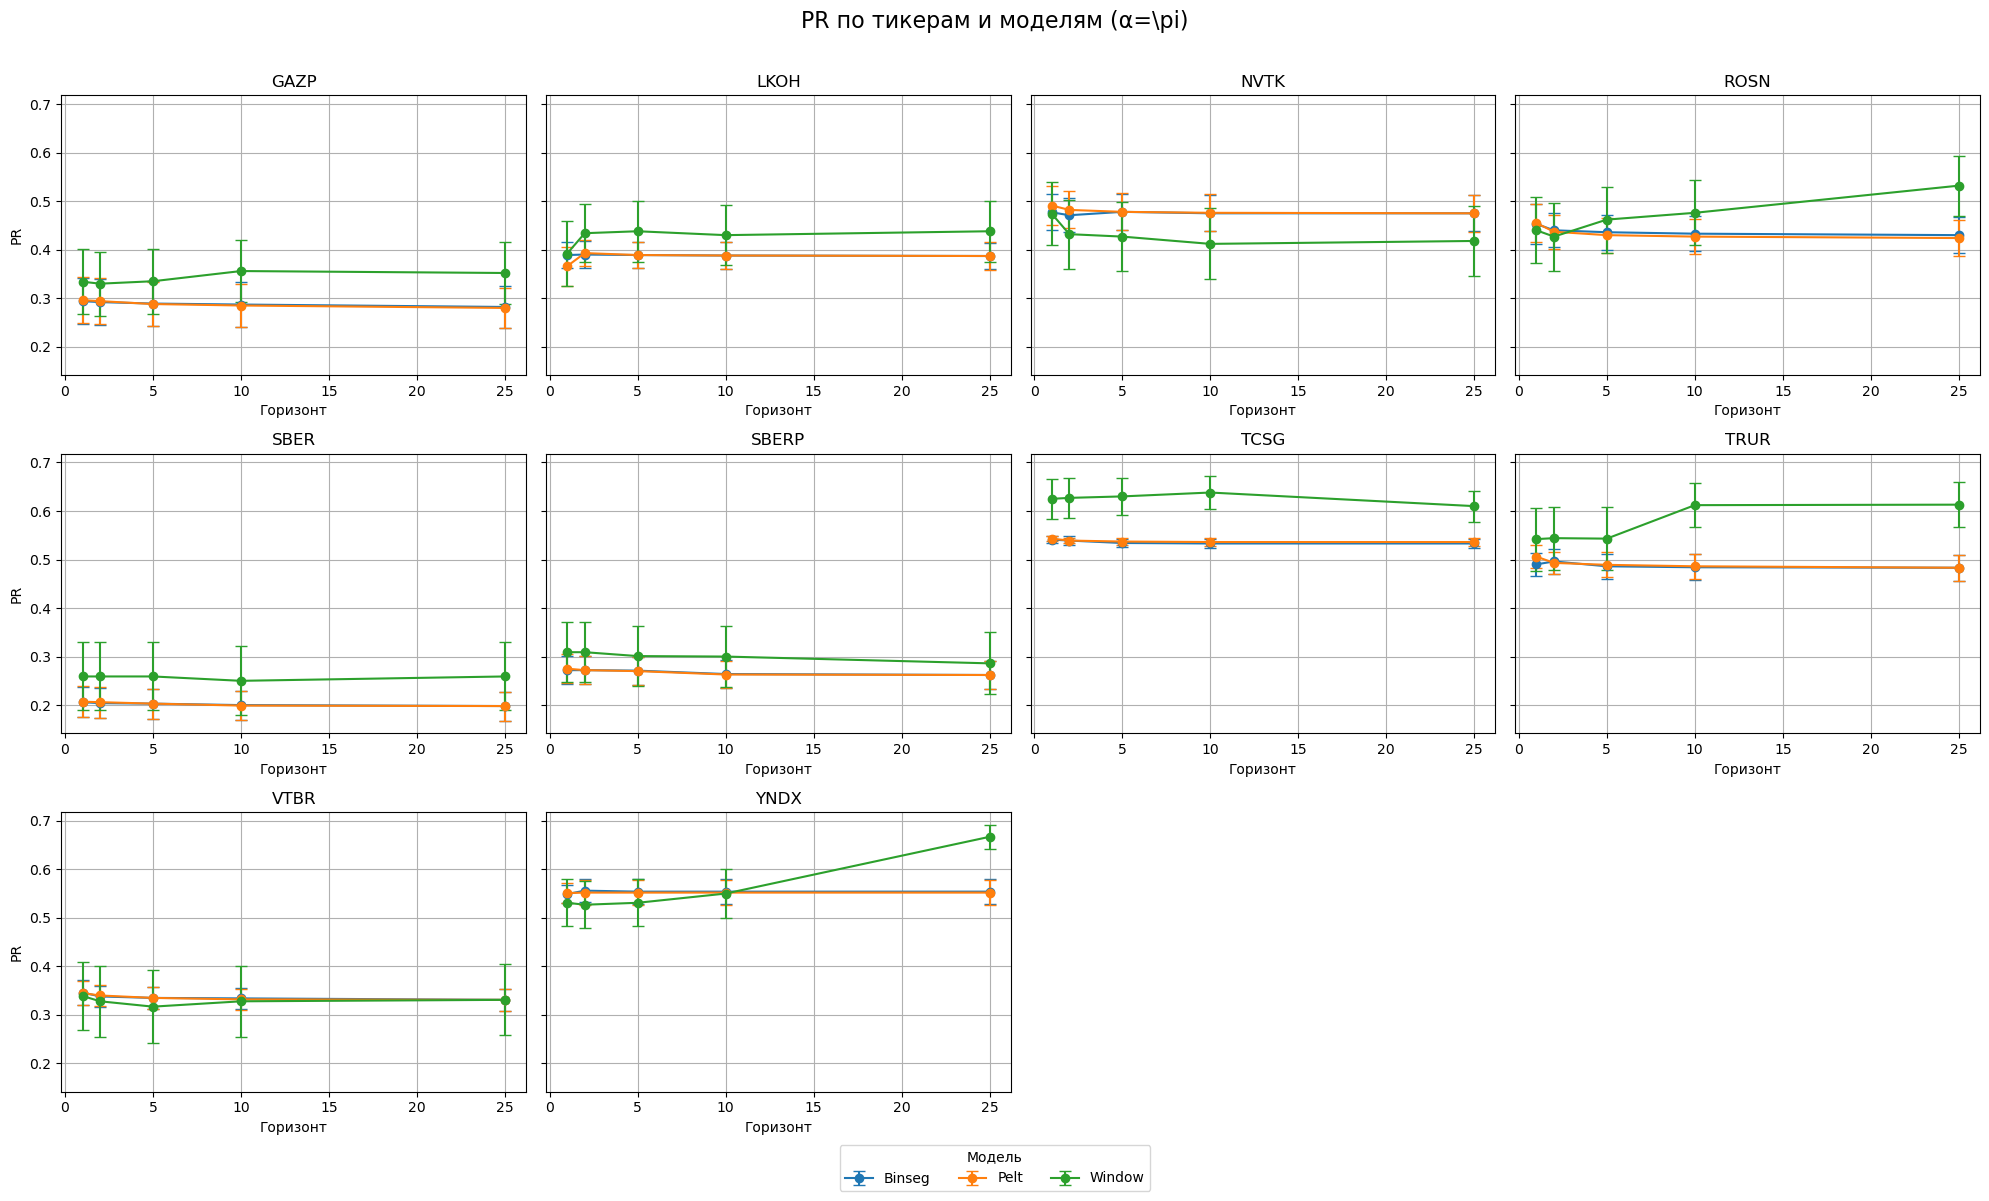

In [38]:
# df = pd.read_csv("all_models_cpd_results_MOEX.csv")

# def parse_metric(val):
#     try:
#         mean, std = val.split(' ± ')
#         return float(mean), float(std)
#     except:
#         return None, None

# df[['mean', 'stderr']] = df['metric_value'].apply(lambda x: pd.Series(parse_metric(x)))

# def plot(df, target_metric="pr"):
#     alphas = df['alpha'].unique()
#     tickers = sorted(df['noise_type'].unique())
#     models = df['model'].unique()

#     for alpha in alphas:
#         df_sub = df[(df['metric_name'] == target_metric) & (df['alpha'] == alpha)]

#         n_cols = 4
#         n_rows = -(-len(tickers) // n_cols)  
#         fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows), sharey=True)
#         axes = axes.flatten()

#         for i, ticker in enumerate(tickers):
#             ax = axes[i]
#             for model in models:
#                 data = df_sub[(df_sub['noise_type'] == ticker) & (df_sub['model'] == model)]

#                 if not data.empty:
#                     ax.errorbar(data['horizon'], data['mean'], yerr=data['stderr'], fmt='-o', capsize=4, label=model)

#             ax.set_title(ticker)
#             ax.set_xlabel("Горизонт")
#             if i % n_cols == 0:
#                 ax.set_ylabel(f"{target_metric.upper()}")
#             ax.grid(True)

#         for j in range(len(tickers), len(axes)):
#             fig.delaxes(axes[j])

#         fig.suptitle(f"{target_metric.upper()} по тикерам и моделям (α={alpha})", fontsize=16)
#         fig.legend(models, title="Модель", loc='lower center', ncol=len(models), bbox_to_anchor=(0.5, -0.01))
#         plt.tight_layout(rect=[0, 0.03, 1, 0.97])
#         plt.show()


# plot(df, target_metric="pr")

Сохранено: pr_Binseg_MOEX.png


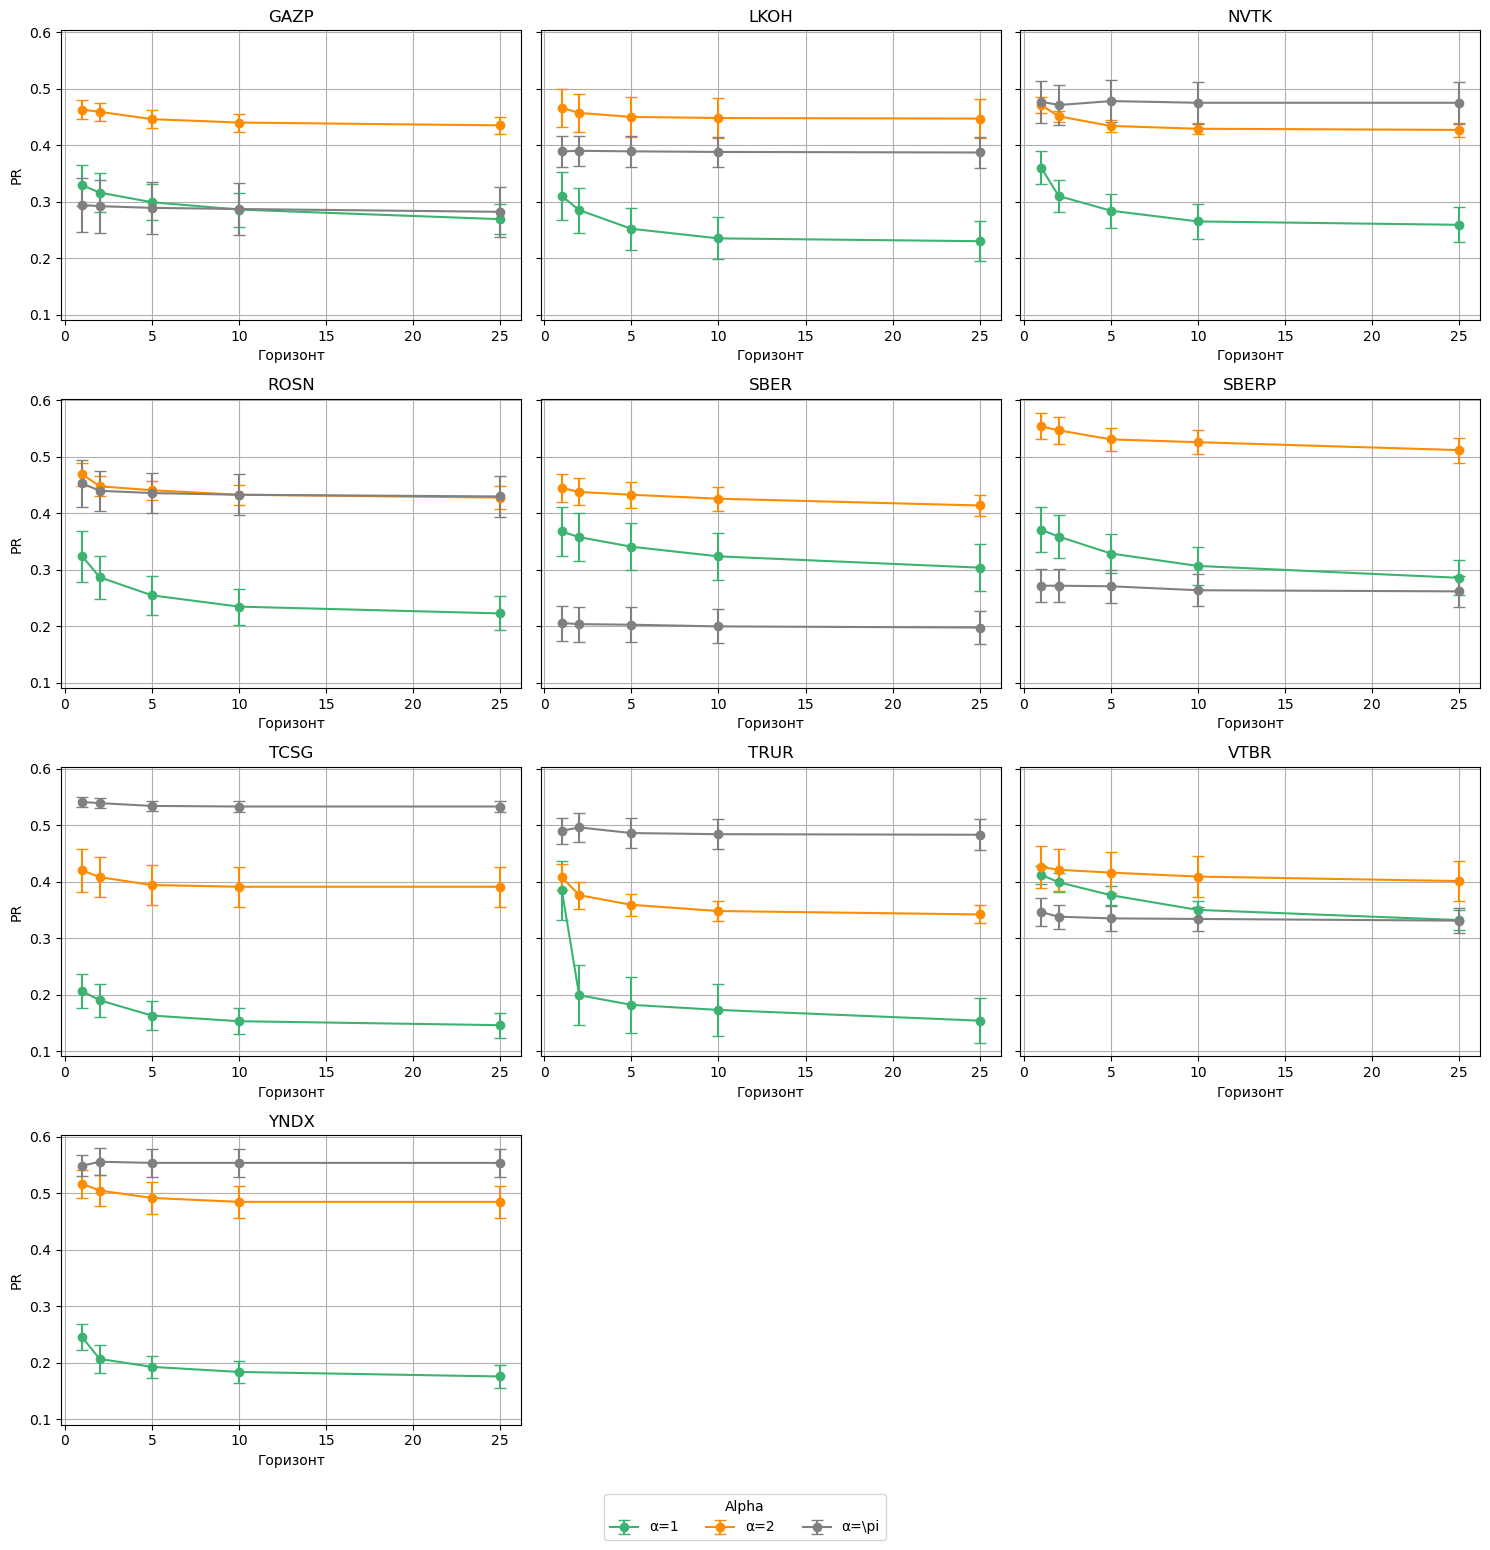

Сохранено: pr_Pelt_MOEX.png


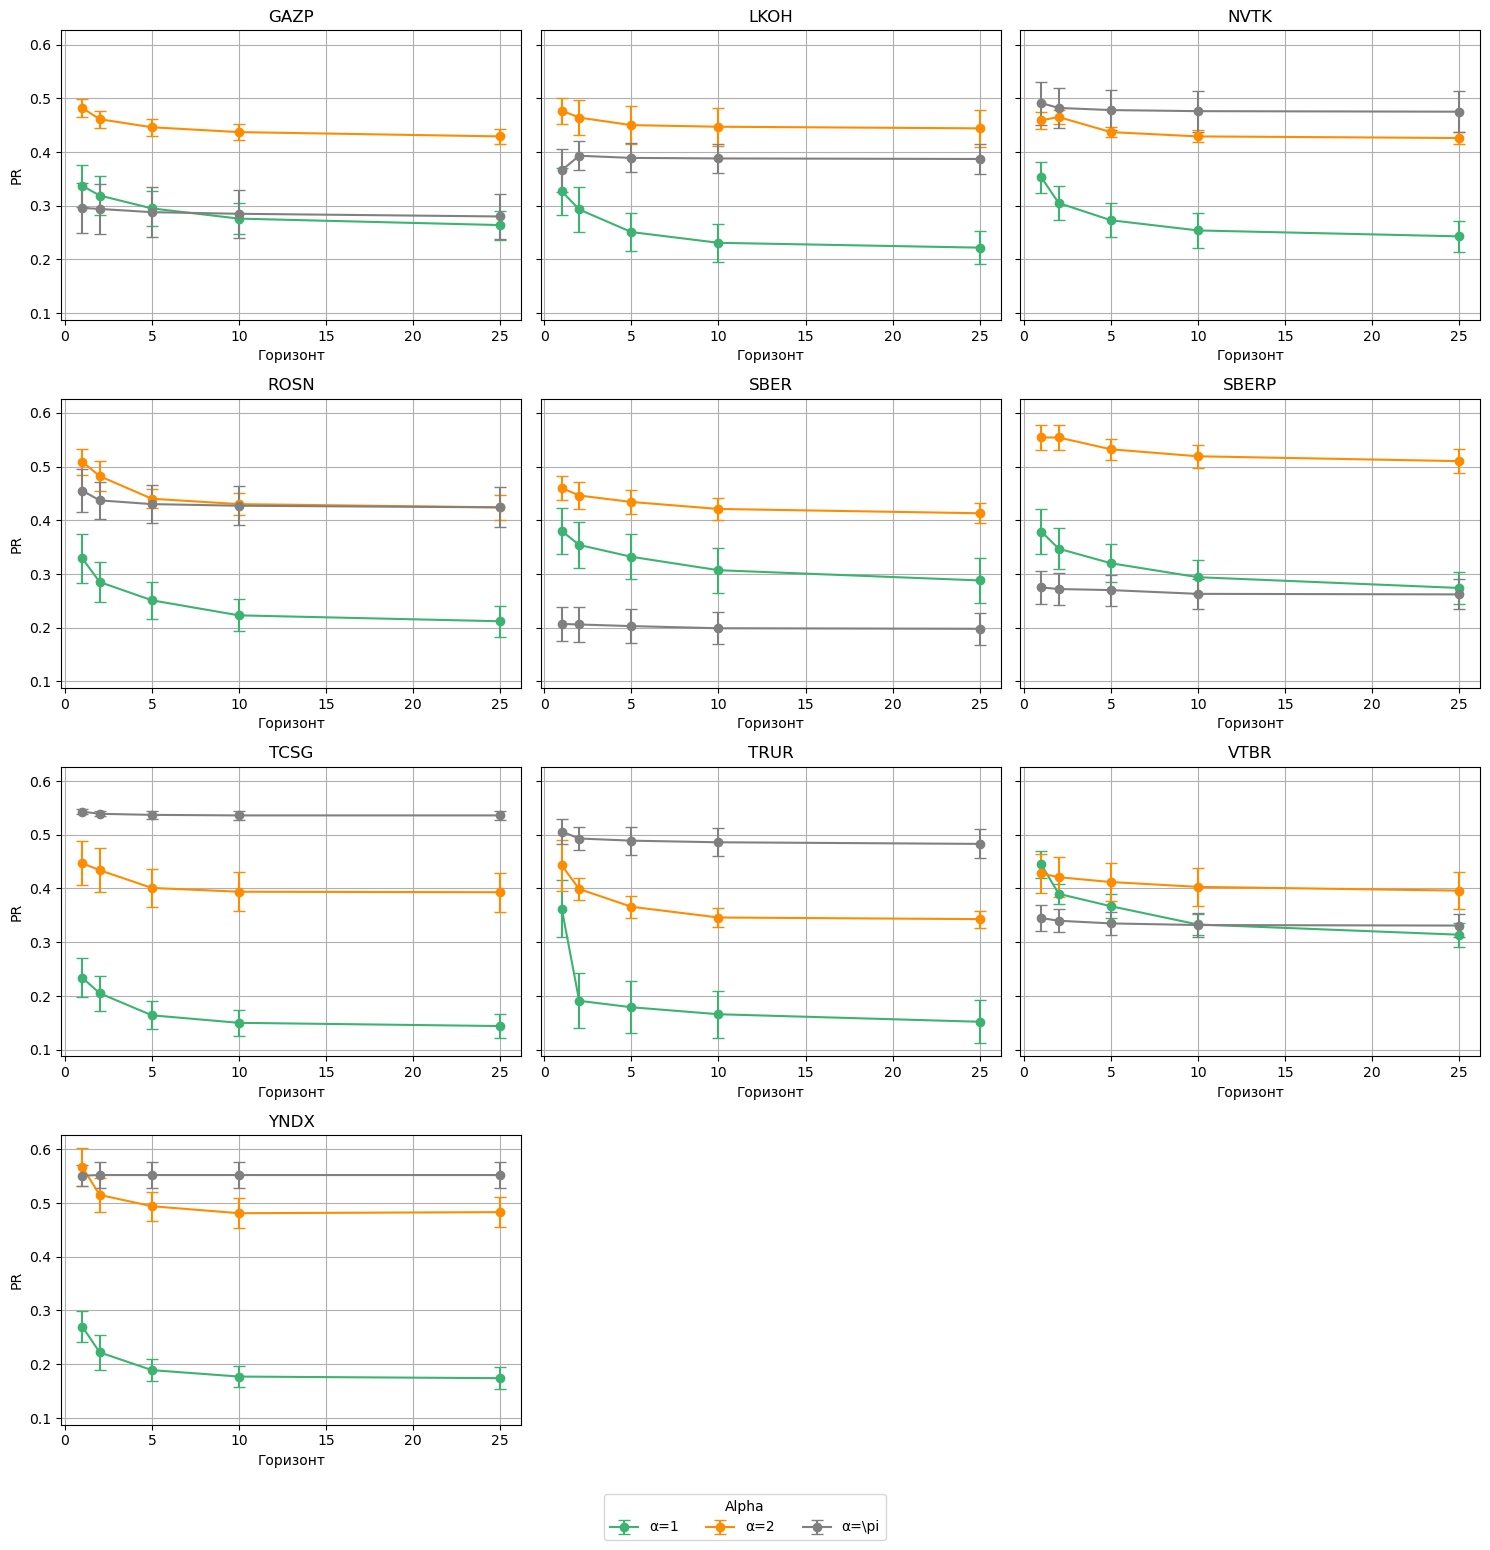

Сохранено: pr_Window_MOEX.png


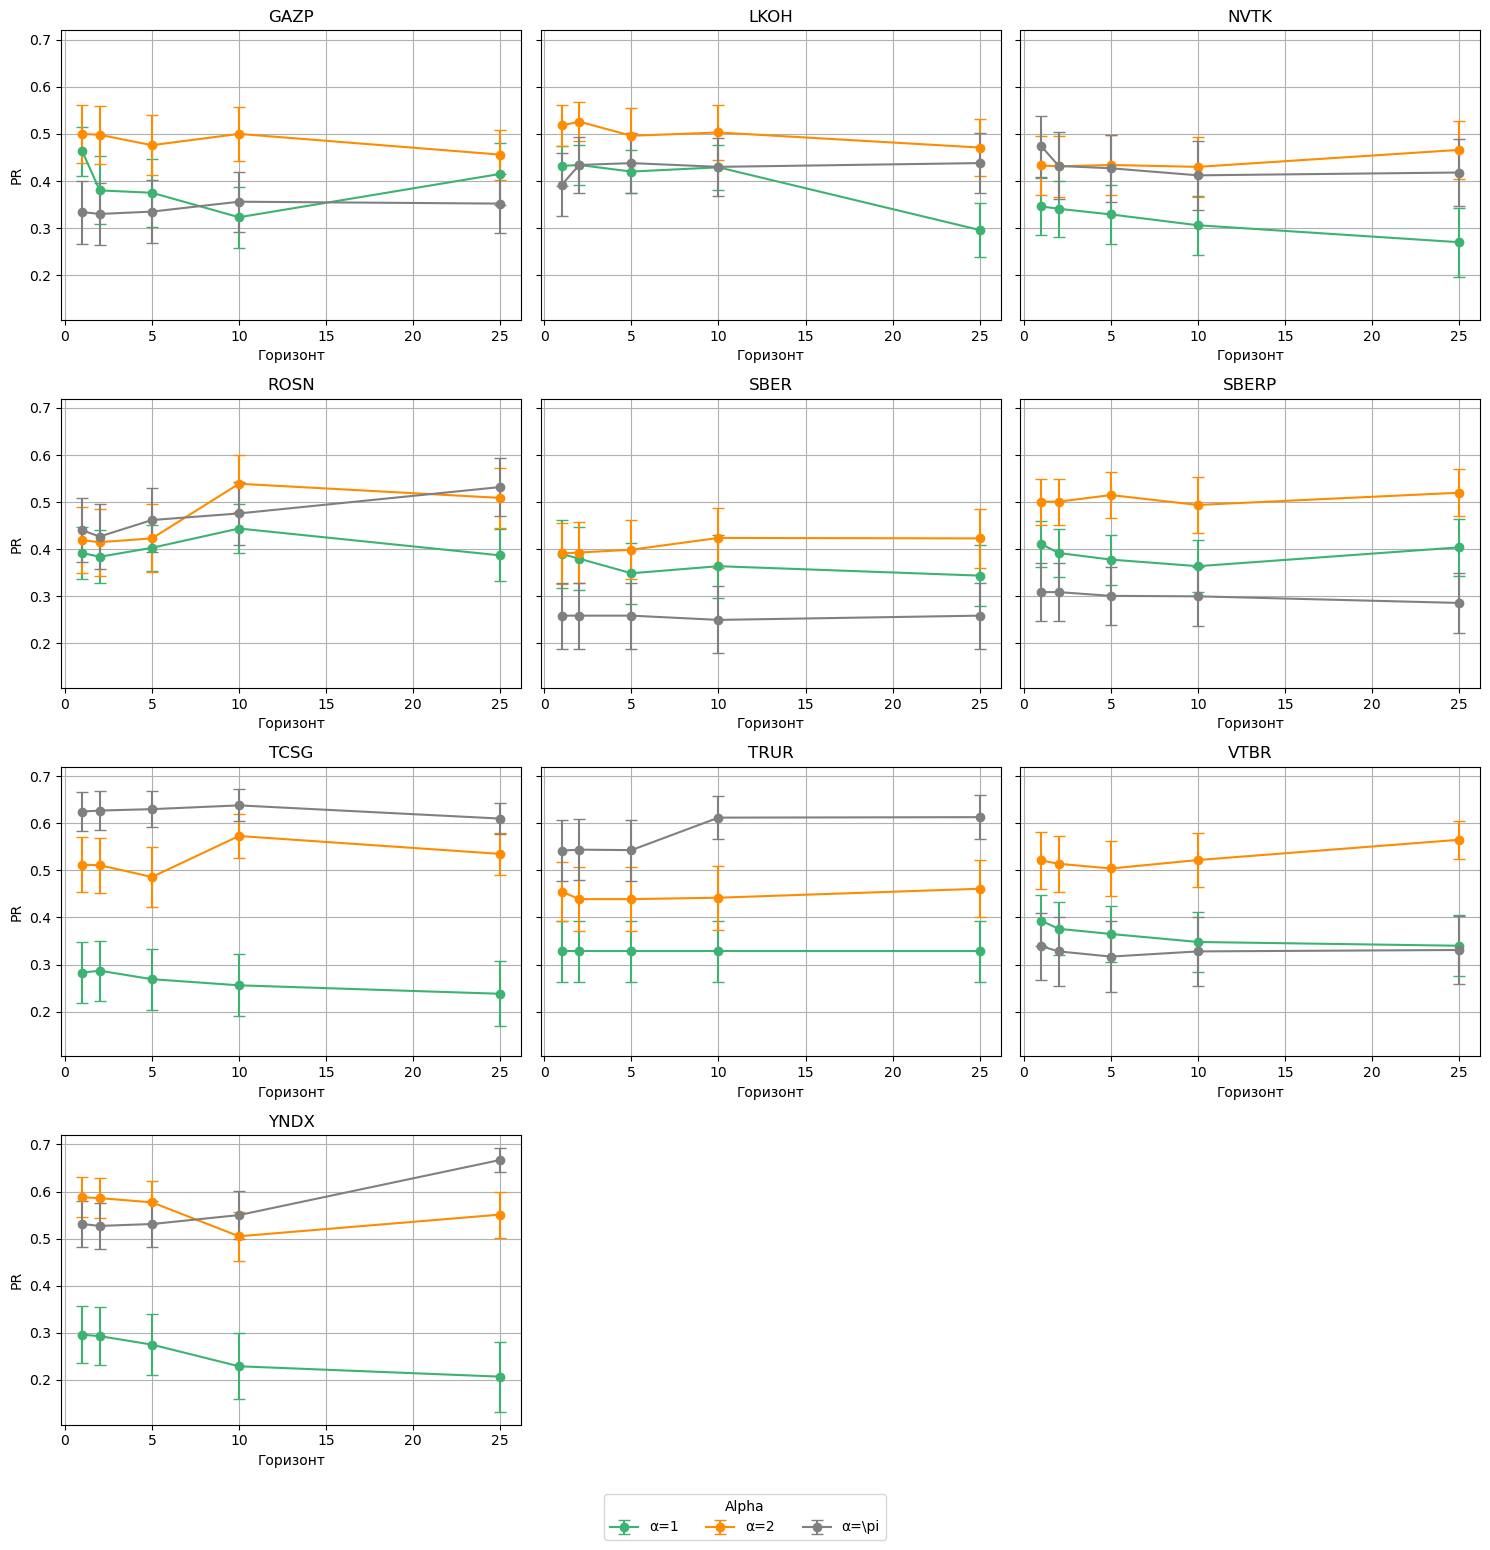

In [60]:
df = pd.read_csv("all_models_cpd_results_MOEX.csv")

def parse_metric(val):
    try:
        mean, std = val.split(' ± ')
        return float(mean), float(std)
    except:
        return None, None

df[['mean', 'stderr']] = df['metric_value'].apply(lambda x: pd.Series(parse_metric(x)))

def plot_grid(df, target_metric="pr"):
    df = df[df['metric_name'] == target_metric]
    tickers = sorted(df['noise_type'].unique())
    models = sorted(df['model'].unique())
    alphas = sorted(df['alpha'].unique())

    color_map = {
        "1": "mediumseagreen",
        "2": "darkorange",
        "3": "crimson"
    }

    n_cols = 3
    n_rows = int(np.ceil(len(tickers) / n_cols))

    for model in models:
        df_model = df[df['model'] == model]

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), sharey=True)
        axes = axes.flatten()

        for i, ticker in enumerate(tickers):
            ax = axes[i]
            df_ticker = df_model[df_model['noise_type'] == ticker]

            for alpha in alphas:
                alpha_str = str(alpha)
                df_alpha = df_ticker[df_ticker['alpha'] == alpha]
                if not df_alpha.empty:
                    ax.errorbar(df_alpha['horizon'], df_alpha['mean'], yerr=df_alpha['stderr'],
                                fmt='-o', label=f"α={alpha}",
                                color=color_map.get(alpha_str, 'gray'),
                                capsize=4)

            ax.set_title(ticker)
            ax.set_xlabel("Горизонт")
            if i % n_cols == 0:
                ax.set_ylabel(target_metric.upper())
            ax.grid(True)

        for j in range(len(tickers), len(axes)):
            fig.delaxes(axes[j])

        #fig.suptitle(f"{target_metric.upper()} по тикерам, модель {model}", fontsize=16)
        handles, labels = ax.get_legend_handles_labels()
        fig.legend(handles, labels, title="Alpha", loc='lower center', ncol=len(alphas), bbox_to_anchor=(0.5, -0.01))
        plt.tight_layout(rect=[0, 0.03, 1, 0.96])
        
        filename = f"{target_metric}_{model}_MOEX.png"
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"Сохранено: {filename}")
        plt.show()

plot_grid(df, target_metric="pr")